<a href="https://colab.research.google.com/github/varunkr24/Machine-Learning/blob/Python/BM_Lock_to_Fund.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import lightgbm as lgb
import pyodbc
import math
import warnings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [ ]:
#Loading the data from model table in SQL Server

sql_conn = pyodbc.connect("DSN=CNPPEDW05")

sql = "select * from Analytics_SB.dbo.BM_lock_fund_Final_model_jan_aug_21 "

df = pd.read_sql(sql, sql_conn)

df.shape

(12427, 51)

In [ ]:
#Loading the data from model table in SQL Server

sql_conn = pyodbc.connect("DSN=CNPPEDW05")

sql = "select * from  Analytics_SB.dbo.BM_lock_fund_Final_model_pipeline"

test = pd.read_sql(sql, sql_conn)

test.shape

(1455, 51)

In [ ]:
#Loading the data from model table in SQL Server
#get the prevailing rates
import pyodbc
sql_conn = pyodbc.connect("DSN=CNPPEDW05")

rate_sql = "Select AsOfDtTm,Today From Analytics_rpt.dbo.rpt_Global_MND_Survey r With (NoLock) Where r.Product = '30 Yr FRM'"

rate = pd.read_sql(rate_sql, sql_conn)

rate.shape

(1367, 2)

In [ ]:
rate.head()

,AsOfDtTm,Today
0,2016-06-15 16:05:00,3.56
1,2016-06-16 15:58:00,3.52
2,2016-06-17 15:04:00,3.53
3,2016-06-21 14:02:00,3.57
4,2016-06-22 15:01:00,3.59


In [ ]:
import datetime as dt
rate['AsOfDtTm'] = rate['AsOfDtTm'].dt.date

In [ ]:
df['InitialLockDt'] = pd.to_datetime(df['InitialLockDt']).dt.date
test['InitialLockDt'] = pd.to_datetime(test['InitialLockDt']).dt.date

In [ ]:
rate.columns = ['AsOfDt','Prevailing_rate']

In [ ]:
#have only one prevaling rate for one date
rate=rate.drop_duplicates(subset='AsOfDt',keep='first')

In [ ]:
rate.shape

(1362, 2)

In [ ]:
#when a date is passed, if the date is later than 2016-06-14, get the latest prevailing rate for that date else null
def latest(date):
    if date >= rate['AsOfDt'].min():
        latest_date = rate[rate['AsOfDt']<=date]['AsOfDt'].max()
        return rate.loc[rate['AsOfDt']==latest_date,'Prevailing_rate'].item()
    else:
        return np.nan

In [ ]:
df['prevailing_rate'] = df['InitialLockDt'].apply(latest)
test['prevailing_rate'] = test['InitialLockDt'].apply(latest)

In [ ]:
df.head()

,LoanNumber,LoanID,CreatedDt,AppDt,InitialLockDt,STUDt,DeniedDt,CancelDt,FundDt,CurrentStatus,CurrentPipelineFlag,LoanAmt,ProdChannel,ProductName,ProductCategory,ProductGroup,ProductSubGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,CLTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,PurposeType,RefinancePurpose,FTHBFlag,Price,FinalPrice,NewConstructionFlag,BasePrice,EverFundedFlag,BW1MonthlyIncomeBase,BW1TotalMonthlyIncome,BW1IsAVeteran,BCalcLTV,BCalcTotalCredits,BCalcTotalLiabilities,BCalcTotalLoanAmount,BCalcUnderwritingTotalStableMonthlyIncome,BCalcCLTV,BCalcBaseUPBFinalPriceAmount,BCalcTotalStableMonthlyIncomeForBorrower,AttributedCampaign,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate
0,9713036086,3583518,2021-05-13,2021-05-14,2021-05-14,2021-05-19,2021-07-14,None,None,Denied,0,187500.0,Consumer Direct,Conforming Texas A6 Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,642.0,75.000,75.000,3.625,30.682,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,True,99.072,1.913,False,0.928,None,1969.20,6760.87,0,75.000,188173.56,18818.0,187500,6760.87,75.000,-3586.875,6760.87,CONV_DM_AggLead_13b,BM_NetTheorem,Net Theorem,Third Party DM,3.14
1,9797657435,3603515,2021-05-24,2021-05-24,2021-05-24,None,None,2021-06-03,None,Canceled,0,188000.0,Consumer Direct,Conforming Fixed 15,Conventional,Conventional,Conventional Fixed,Conventional,Full,180,739.0,37.228,37.228,2.750,40.096,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,False,98.112,0.763,False,1.888,None,0.00,6022.00,1,37.228,188000.00,40726.0,188000,6022.00,37.228,-1434.440,6022.00,LongForm Warm_BM,Dialer BM,Lending Tree,Lead Agg - Warm Xfer,3.14
2,9745002080,3276322,2020-12-31,2021-01-04,2021-01-04,2021-01-07,None,2021-02-25,None,Canceled,0,292000.0,Consumer Direct,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,765.0,73.000,73.000,2.800,40.544,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,True,98.330,2.135,False,1.670,None,1546.00,7337.46,0,73.000,292475.00,25321.0,292000,7337.46,73.000,-6234.200,7337.46,CONV_DM_AggLead,BM_NetTheorem,Net Theorem,Third Party DM,2.76
3,9757181152,3643294,2021-06-11,2021-06-11,2021-06-11,None,None,2021-07-22,None,Canceled,0,181500.0,Consumer Direct,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,758.0,72.600,72.600,2.950,41.810,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,False,97.065,0.810,False,2.935,None,5328.27,5328.27,0,72.600,182048.56,82676.0,181500,5328.27,72.600,-1470.150,5328.27,FHA_DM_AggLead_May25_A4,BM_NetTheorem,Net Theorem,Third Party DM,3.03
4,9740352050,3609388,2021-05-26,2021-05-26,2021-05-26,None,None,2021-05-28,None,Canceled,0,125000.0,Consumer Direct,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,796.0,39.063,39.063,3.250,31.446,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,True,98.318,0.000,False,1.682,None,0.00,1045.00,0,39.063,125473.56,4449.0,125000,4692.78,39.063,0.000,1045.00,Lead Point Realtime_BM,BM_Lead Point,Lead Point,Lead Agg - Real Time,3.07


In [ ]:
df['InitialLockDt'].nunique()

207

In [ ]:
df['prevailing_rate'].isnull().sum()

0

In [ ]:
test['prevailing_rate'].isnull().sum()

0

In [ ]:
df.shape

(12427, 52)

In [ ]:
df.to_csv('BM_lock_fund_final_03_12_21.csv',index=False)

In [ ]:
#df = pd.read_csv('BM_lock_fund_final_09_09.csv')
df.shape

(12427, 52)

In [ ]:
df.isnull().sum()

LoanNumber                                       0
LoanID                                           0
CreatedDt                                        0
AppDt                                           14
InitialLockDt                                    0
STUDt                                         4404
DeniedDt                                     10484
CancelDt                                      6572
FundDt                                        7843
CurrentStatus                                    0
CurrentPipelineFlag                              0
LoanAmt                                          0
ProdChannel                                      0
ProductName                                      0
ProductCategory                                  0
ProductGroup                                     0
ProductSubGroup                                  0
LoanType                                         0
DocumentType                                     0
AmortizationTerm               

In [ ]:
df.isnull().mean()*100

LoanNumber                                    0.000000
LoanID                                        0.000000
CreatedDt                                     0.000000
AppDt                                         0.112658
InitialLockDt                                 0.000000
STUDt                                        35.438964
DeniedDt                                     84.364690
CancelDt                                     52.884848
FundDt                                       63.112577
CurrentStatus                                 0.000000
CurrentPipelineFlag                           0.000000
LoanAmt                                       0.000000
ProdChannel                                   0.000000
ProductName                                   0.000000
ProductCategory                               0.000000
ProductGroup                                  0.000000
ProductSubGroup                               0.000000
LoanType                                      0.000000
DocumentTy

In [ ]:
df.head()

,LoanNumber,LoanID,CreatedDt,AppDt,InitialLockDt,STUDt,DeniedDt,CancelDt,FundDt,CurrentStatus,CurrentPipelineFlag,LoanAmt,ProdChannel,ProductName,ProductCategory,ProductGroup,ProductSubGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,CLTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,PurposeType,RefinancePurpose,FTHBFlag,Price,FinalPrice,NewConstructionFlag,BasePrice,EverFundedFlag,BW1MonthlyIncomeBase,BW1TotalMonthlyIncome,BW1IsAVeteran,BCalcLTV,BCalcTotalCredits,BCalcTotalLiabilities,BCalcTotalLoanAmount,BCalcUnderwritingTotalStableMonthlyIncome,BCalcCLTV,BCalcBaseUPBFinalPriceAmount,BCalcTotalStableMonthlyIncomeForBorrower,AttributedCampaign,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate
0,9713036086,3583518,2021-05-13,2021-05-14,2021-05-14,2021-05-19,2021-07-14,None,None,Denied,0,187500.0,Consumer Direct,Conforming Texas A6 Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,642.0,75.000,75.000,3.625,30.682,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,True,99.072,1.913,False,0.928,None,1969.20,6760.87,0,75.000,188173.56,18818.0,187500,6760.87,75.000,-3586.875,6760.87,CONV_DM_AggLead_13b,BM_NetTheorem,Net Theorem,Third Party DM,3.14
1,9797657435,3603515,2021-05-24,2021-05-24,2021-05-24,None,None,2021-06-03,None,Canceled,0,188000.0,Consumer Direct,Conforming Fixed 15,Conventional,Conventional,Conventional Fixed,Conventional,Full,180,739.0,37.228,37.228,2.750,40.096,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,False,98.112,0.763,False,1.888,None,0.00,6022.00,1,37.228,188000.00,40726.0,188000,6022.00,37.228,-1434.440,6022.00,LongForm Warm_BM,Dialer BM,Lending Tree,Lead Agg - Warm Xfer,3.14
2,9745002080,3276322,2020-12-31,2021-01-04,2021-01-04,2021-01-07,None,2021-02-25,None,Canceled,0,292000.0,Consumer Direct,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,765.0,73.000,73.000,2.800,40.544,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,True,98.330,2.135,False,1.670,None,1546.00,7337.46,0,73.000,292475.00,25321.0,292000,7337.46,73.000,-6234.200,7337.46,CONV_DM_AggLead,BM_NetTheorem,Net Theorem,Third Party DM,2.76
3,9757181152,3643294,2021-06-11,2021-06-11,2021-06-11,None,None,2021-07-22,None,Canceled,0,181500.0,Consumer Direct,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,758.0,72.600,72.600,2.950,41.810,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,False,97.065,0.810,False,2.935,None,5328.27,5328.27,0,72.600,182048.56,82676.0,181500,5328.27,72.600,-1470.150,5328.27,FHA_DM_AggLead_May25_A4,BM_NetTheorem,Net Theorem,Third Party DM,3.03
4,9740352050,3609388,2021-05-26,2021-05-26,2021-05-26,None,None,2021-05-28,None,Canceled,0,125000.0,Consumer Direct,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,360,796.0,39.063,39.063,3.250,31.446,Primary Residence,Detached,1,Refinance,C/O: Debt Consol,True,98.318,0.000,False,1.682,None,0.00,1045.00,0,39.063,125473.56,4449.0,125000,4692.78,39.063,0.000,1045.00,Lead Point Realtime_BM,BM_Lead Point,Lead Point,Lead Agg - Real Time,3.07


In [ ]:
df['CurrentStatus'].value_counts()

Canceled           5855
Funded             4584
Denied             1943
Active Pipeline      45
Name: CurrentStatus, dtype: int64

In [ ]:
df['CurrentStatus'].value_counts(normalize=True)

Canceled           0.471152
Funded             0.368874
Denied             0.156353
Active Pipeline    0.003621
Name: CurrentStatus, dtype: float64

In [ ]:
df[~(df['CurrentStatus'].isin(['Active Pipeline','Pre-App Pipeline']))].shape

(12382, 52)

In [ ]:
# Removing the loans which are pre-app pipeline or active pipeline as we don't know the exact output of these loans (funded or not)
df = df[~(df['CurrentStatus'].isin(['Active Pipeline','Pre-App Pipeline']))]
df.shape

(12382, 52)

In [ ]:
df['Campaign_Group'].value_counts()

Net Theorem                5567
Other                      1008
Website                     672
Iconic Results              635
Assurance                   608
Conversion King             584
Unattributed                581
ILG                         481
Lead Point                  429
Lending Tree                405
Past Customer               340
Dialer                      225
Credit Triggers              91
EXL Service                  90
Suited Connector             83
Servicing Xfer               80
Acquisition                  64
Real Time Leads              56
Benefit                      51
Third Party DM               48
General Quick Quote          43
Adhoc Blast                  40
Belo                         35
RGR Marketing                34
Shark Tank                   22
PX                           20
Jornaya Activate             11
Unknown                      10
Digital Marketing            10
Ileads Defender               9
iLeads                        9
Servicin

In [ ]:
df['Marketing_Group'].value_counts()

Third Party DM           5213
Lead Agg - Warm Xfer     2873
Other                     976
Website                   682
Unattributed              581
ILG                       481
Past Customer             343
Lead Agg - Real Time      272
Dialer                    229
Lead Remarketing          173
Digital                    99
3rd Party DM               97
Servicing                  93
Triggers / Signals         86
Email Marketing            74
DM Marketing               44
Shark Tank                 15
Unknown                    10
Lead Agg - Batch           10
Fedex Marketing             8
LC Call List                5
Contact Followup            4
Monthly Benefit DM          3
Prospecting                 3
Adhoc Email                 2
Quick Quote                 2
Caller ID Callback          2
Credit Trigger DM           1
Monthly Benefit Email       1
Name: Marketing_Group, dtype: int64

This is the data that should be taken.

In [ ]:
df.isnull().mean()*100

LoanNumber                                    0.000000
LoanID                                        0.000000
CreatedDt                                     0.000000
AppDt                                         0.113067
InitialLockDt                                 0.000000
STUDt                                        35.567760
DeniedDt                                     84.307866
CancelDt                                     52.713617
FundDt                                       62.978517
CurrentStatus                                 0.000000
CurrentPipelineFlag                           0.000000
LoanAmt                                       0.000000
ProdChannel                                   0.000000
ProductName                                   0.000000
ProductCategory                               0.000000
ProductGroup                                  0.000000
ProductSubGroup                               0.000000
LoanType                                      0.000000
DocumentTy

In [ ]:
df['Fund'] = np.where(df['FundDt'].isnull(), 0, 1)
df['FTHBFlag'] = np.where(df['FTHBFlag'] == True, 'TRUE', 'FALSE')
test['FTHBFlag'] = np.where(test['FTHBFlag'] == True, 'TRUE', 'FALSE')

In [ ]:
df['RefinancePurpose'].value_counts()

No C/O: Rate/Term    7765
C/O: Debt Consol     3817
C/O: Other            203
Limited C/O            54
C/O: Home Imp          32
Name: RefinancePurpose, dtype: int64

In [ ]:
df['PurposeType'].value_counts(normalize=True)

Refinance                 0.958730
Purchase                  0.041189
Construction-Permanent    0.000081
Name: PurposeType, dtype: float64

In [ ]:
for col in df.columns:
    print(col)

LoanNumber
LoanID
CreatedDt
AppDt
InitialLockDt
STUDt
DeniedDt
CancelDt
FundDt
CurrentStatus
CurrentPipelineFlag
LoanAmt
ProdChannel
ProductName
ProductCategory
ProductGroup
ProductSubGroup
LoanType
DocumentType
AmortizationTerm
FICO
LTV
CLTV
Rate
DTI
ResidencyType
PropertyType
NumberOfUnits
PurposeType
RefinancePurpose
FTHBFlag
Price
FinalPrice
NewConstructionFlag
BasePrice
EverFundedFlag
BW1MonthlyIncomeBase
BW1TotalMonthlyIncome
BW1IsAVeteran
BCalcLTV
BCalcTotalCredits
BCalcTotalLiabilities
BCalcTotalLoanAmount
BCalcUnderwritingTotalStableMonthlyIncome
BCalcCLTV
BCalcBaseUPBFinalPriceAmount
BCalcTotalStableMonthlyIncomeForBorrower
AttributedCampaign
AttributedCampaignCategory
Campaign_Group
Marketing_Group
prevailing_rate
Fund


In [ ]:
stu_df = df[['LoanNumber','STUDt']]

In [ ]:
not_req_cols = ['CreatedDt'
                ,'LoanID'
                ,'AppDt'    # Removing all the stage variables such as STUDt, CurrentPipelineFlag, DeniedDt, CancelDt which are not required for modeling.
                ,'STUDt'
                ,'DeniedDt'
                ,'CancelDt'
                ,'CurrentPipelineFlag'
                ,'FundDt'
                ,'Price'
                ,'BasePrice'
                ,'EverFundedFlag' # Similar to Fund (target column) and creates target leakage
                ,'BW1MonthlyIncomeBase' # we have the total monthly income variable and this variable has lot of missing values.
                ,'ProdChannel' # Removing this variable as it contains only one value which is consumer direct
                #,'num_of_units' # we have similar variable called 'NumberOfUnits'
                ,'BCalcLTV' # we have LTV and CLTV from atlas table
                ,'BCalcCLTV'
                ,'CLTV'  # Combined loan to value (CLTV) 99.26% same as LTV   
                #,'OrigPIPmt'
                #,'Product_Type_Orig'
                ,'BW1TotalMonthlyIncome' # Removing these monthly income columns as we have BCalcUnderwritingTotalStableMonthlyIncome which is important
                ,'BCalcTotalStableMonthlyIncomeForBorrower'
                ,'CurrentStatus' # we can remove this as we cannot have this variable during predicting on the test data
                #,'srvcr_portf_type' # It has only single value which we don't require for modeling
                ,'PurposeType' # 99.99% is made of refinance
                #,'borrw_dti_back' # No variance
#                 ,'loan_type' # we have another LoanType variable which we are using for modeling
               ] 

In [ ]:
df = df.drop(not_req_cols, axis=1)
test = test.drop(not_req_cols, axis=1)
df.isnull().mean()*100

LoanNumber                                   0.000000
InitialLockDt                                0.000000
LoanAmt                                      0.000000
ProductName                                  0.000000
ProductCategory                              0.000000
ProductGroup                                 0.000000
ProductSubGroup                              0.000000
LoanType                                     0.000000
DocumentType                                 0.000000
AmortizationTerm                             0.000000
FICO                                         0.977225
LTV                                          0.000000
Rate                                         0.000000
DTI                                          0.000000
ResidencyType                                0.000000
PropertyType                                 0.000000
NumberOfUnits                                0.000000
RefinancePurpose                             4.126958
FTHBFlag                    

In [ ]:
print(df.shape)
print(test.shape)

(12382, 33)
(1455, 32)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12382 entries, 0 to 12426
Data columns (total 33 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   LoanNumber                                 12382 non-null  object 
 1   InitialLockDt                              12382 non-null  object 
 2   LoanAmt                                    12382 non-null  float64
 3   ProductName                                12382 non-null  object 
 4   ProductCategory                            12382 non-null  object 
 5   ProductGroup                               12382 non-null  object 
 6   ProductSubGroup                            12382 non-null  object 
 7   LoanType                                   12382 non-null  object 
 8   DocumentType                               12382 non-null  object 
 9   AmortizationTerm                           12382 non-null  int64  
 10  FICO                  

In [ ]:
df['Fund'].value_counts(normalize=True)*100

0    62.978517
1    37.021483
Name: Fund, dtype: float64

### get datatypes

In [ ]:
def type_columns(df,type_req):
    type_req_cols = df.select_dtypes(include =[type_req]).columns
    return(type_req_cols.to_list())

In [ ]:
int_cols = type_columns(df,'int64')
int_cols

['AmortizationTerm',
 'NumberOfUnits',
 'BW1IsAVeteran',
 'BCalcTotalLoanAmount',
 'Fund']

In [ ]:
float_cols = type_columns(df, 'float64')
float_cols

['LoanAmt',
 'FICO',
 'LTV',
 'Rate',
 'DTI',
 'FinalPrice',
 'BCalcTotalCredits',
 'BCalcTotalLiabilities',
 'BCalcUnderwritingTotalStableMonthlyIncome',
 'BCalcBaseUPBFinalPriceAmount',
 'prevailing_rate']

In [ ]:
object_cols = type_columns(df, 'object')
object_cols

['LoanNumber',
 'InitialLockDt',
 'ProductName',
 'ProductCategory',
 'ProductGroup',
 'ProductSubGroup',
 'LoanType',
 'DocumentType',
 'ResidencyType',
 'PropertyType',
 'RefinancePurpose',
 'FTHBFlag',
 'NewConstructionFlag',
 'AttributedCampaign',
 'AttributedCampaignCategory',
 'Campaign_Group',
 'Marketing_Group']

In [ ]:
len(int_cols) + len(float_cols) + len(object_cols)

33

In [ ]:
df.shape

(12382, 33)

In [ ]:
df[int_cols].head()

,AmortizationTerm,NumberOfUnits,BW1IsAVeteran,BCalcTotalLoanAmount,Fund
0,360,1,0,187500,0
1,180,1,1,188000,0
2,360,1,0,292000,0
3,360,1,0,181500,0
4,360,1,0,125000,0


In [ ]:
df['BW1IsAVeteran'] =  np.where(df['BW1IsAVeteran'] == 1, 'TRUE', 'FALSE')
test['BW1IsAVeteran'] =  np.where(test['BW1IsAVeteran'] == 1, 'TRUE', 'FALSE')
int_cols.remove('BW1IsAVeteran')
object_cols.append('BW1IsAVeteran')

In [ ]:
df[int_cols].head()

,AmortizationTerm,NumberOfUnits,BCalcTotalLoanAmount,Fund
0,360,1,187500,0
1,180,1,188000,0
2,360,1,292000,0
3,360,1,181500,0
4,360,1,125000,0


In [ ]:
df['AmortizationTerm'].value_counts()

360    10082
180     1373
240      460
300      249
120      150
324        9
336        7
96         6
156        5
252        5
312        5
144        5
288        4
348        4
204        3
228        3
264        3
276        3
132        2
168        2
192        1
316        1
Name: AmortizationTerm, dtype: int64

In [ ]:
df[float_cols].head()

,LoanAmt,FICO,LTV,Rate,DTI,FinalPrice,BCalcTotalCredits,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,prevailing_rate
0,187500.0,642.0,75.000,3.625,30.682,1.913,188173.56,18818.0,6760.87,-3586.875,3.14
1,188000.0,739.0,37.228,2.750,40.096,0.763,188000.00,40726.0,6022.00,-1434.440,3.14
2,292000.0,765.0,73.000,2.800,40.544,2.135,292475.00,25321.0,7337.46,-6234.200,2.76
3,181500.0,758.0,72.600,2.950,41.810,0.810,182048.56,82676.0,5328.27,-1470.150,3.03
4,125000.0,796.0,39.063,3.250,31.446,0.000,125473.56,4449.0,4692.78,0.000,3.07


In [ ]:
df[float_cols].nunique()

LoanAmt                                       6096
FICO                                           261
LTV                                           8358
Rate                                            64
DTI                                          10014
FinalPrice                                    4808
BCalcTotalCredits                             9816
BCalcTotalLiabilities                        10415
BCalcUnderwritingTotalStableMonthlyIncome     8697
BCalcBaseUPBFinalPriceAmount                 10790
prevailing_rate                                 62
dtype: int64

In [ ]:
df[object_cols].head()

,LoanNumber,InitialLockDt,ProductName,ProductCategory,ProductGroup,ProductSubGroup,LoanType,DocumentType,ResidencyType,PropertyType,RefinancePurpose,FTHBFlag,NewConstructionFlag,AttributedCampaign,AttributedCampaignCategory,Campaign_Group,Marketing_Group,BW1IsAVeteran
0,9713036086,2021-05-14,Conforming Texas A6 Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,TRUE,False,CONV_DM_AggLead_13b,BM_NetTheorem,Net Theorem,Third Party DM,FALSE
1,9797657435,2021-05-24,Conforming Fixed 15,Conventional,Conventional,Conventional Fixed,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,FALSE,False,LongForm Warm_BM,Dialer BM,Lending Tree,Lead Agg - Warm Xfer,TRUE
2,9745002080,2021-01-04,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,TRUE,False,CONV_DM_AggLead,BM_NetTheorem,Net Theorem,Third Party DM,FALSE
3,9757181152,2021-06-11,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,FALSE,False,FHA_DM_AggLead_May25_A4,BM_NetTheorem,Net Theorem,Third Party DM,FALSE
4,9740352050,2021-05-26,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,TRUE,False,Lead Point Realtime_BM,BM_Lead Point,Lead Point,Lead Agg - Real Time,FALSE


In [ ]:
object_cols.remove('LoanNumber')

In [ ]:
df[object_cols].nunique()

InitialLockDt                 207
ProductName                    33
ProductCategory                 3
ProductGroup                    6
ProductSubGroup                 9
LoanType                        3
DocumentType                    2
ResidencyType                   3
PropertyType                    7
RefinancePurpose                5
FTHBFlag                        2
NewConstructionFlag             2
AttributedCampaign            359
AttributedCampaignCategory     52
Campaign_Group                 47
Marketing_Group                29
BW1IsAVeteran                   2
dtype: int64

### EDA object cols

In [ ]:
df[['ProductName','ProductCategory','ProductGroup','ProductSubGroup']].drop_duplicates().reset_index()

,index,ProductName,ProductCategory,ProductGroup,ProductSubGroup
0,0,Conforming Texas A6 Fixed 30,Conventional,Conventional,Conventional Fixed
1,1,Conforming Fixed 15,Conventional,Conventional,Conventional Fixed
2,2,Conforming Fixed 30,Conventional,Conventional,Conventional Fixed
3,11,Conforming Home Possible Fixed 30,Conventional,Conventional,Conventional Fixed
4,13,FHA Fixed 30,Government,FHA,FHA Fixed
5,22,VA Fixed 30,Government,VA,VA Fixed
6,38,FHA Fixed 15,Government,FHA,FHA Fixed
7,46,Conforming Fixed 20,Conventional,Conventional,Conventional Fixed
8,54,FHA Fixed 25,Government,FHA,FHA Fixed
9,69,Caliber Sprint Fixed 30,Conventional,Conventional,Conventional Fixed


In [ ]:
df[['ProductName','ProductCategory','ProductGroup','ProductSubGroup']].nunique()

ProductName        33
ProductCategory     3
ProductGroup        6
ProductSubGroup     9
dtype: int64

In [ ]:
#### We can just keep product group and remove the others
df.drop(['ProductName','ProductCategory','ProductSubGroup'],axis=1,inplace = True)
test.drop(['ProductName','ProductCategory','ProductSubGroup'],axis=1,inplace = True)
object_cols = [x for x in object_cols if x not in ['ProductName','ProductCategory','ProductSubGroup']]

In [ ]:
df[['AttributedCampaign','AttributedCampaignCategory']].drop_duplicates().reset_index()

,index,AttributedCampaign,AttributedCampaignCategory
0,0,CONV_DM_AggLead_13b,BM_NetTheorem
1,1,LongForm Warm_BM,Dialer BM
2,2,CONV_DM_AggLead,BM_NetTheorem
3,3,FHA_DM_AggLead_May25_A4,BM_NetTheorem
4,4,Lead Point Realtime_BM,BM_Lead Point
5,6,Digital Web Quick Quote,Quick Quote
6,7,Suited Connector Warm_BM,BM_Suited Connector
7,8,Portfolio Loan,Unknown
8,9,$$_CreditTrigger_Fedex,Adhoc
9,10,RGR_Realtime_BM,BM_RGR


In [ ]:
df[['AttributedCampaign','AttributedCampaignCategory']].nunique()

AttributedCampaign            359
AttributedCampaignCategory     52
dtype: int64

In [ ]:
df.drop('AttributedCampaign',axis=1,inplace=True)
test.drop('AttributedCampaign',axis=1,inplace=True)
object_cols.remove('AttributedCampaign')

In [ ]:
df.drop('InitialLockDt',axis=1,inplace=True)
test.drop('InitialLockDt',axis=1,inplace=True)
object_cols.remove('InitialLockDt')

In [ ]:
df[object_cols].head()

,ProductGroup,LoanType,DocumentType,ResidencyType,PropertyType,RefinancePurpose,FTHBFlag,NewConstructionFlag,AttributedCampaignCategory,Campaign_Group,Marketing_Group,BW1IsAVeteran
0,Conventional,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,TRUE,False,BM_NetTheorem,Net Theorem,Third Party DM,FALSE
1,Conventional,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,FALSE,False,Dialer BM,Lending Tree,Lead Agg - Warm Xfer,TRUE
2,Conventional,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,TRUE,False,BM_NetTheorem,Net Theorem,Third Party DM,FALSE
3,Conventional,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,FALSE,False,BM_NetTheorem,Net Theorem,Third Party DM,FALSE
4,Conventional,Conventional,Full,Primary Residence,Detached,C/O: Debt Consol,TRUE,False,BM_Lead Point,Lead Point,Lead Agg - Real Time,FALSE


In [ ]:
df[object_cols].nunique()

ProductGroup                   6
LoanType                       3
DocumentType                   2
ResidencyType                  3
PropertyType                   7
RefinancePurpose               5
FTHBFlag                       2
NewConstructionFlag            2
AttributedCampaignCategory    52
Campaign_Group                47
Marketing_Group               29
BW1IsAVeteran                  2
dtype: int64

In [ ]:
len(object_cols)

12

In [ ]:
for col in object_cols:
    try:
        df[col] = df[col].str.upper()
        test[col] = test[col].str.upper()
    except:
        print(col)

NewConstructionFlag


In [ ]:
def barplots_perc(df,start_col_num,end_col_num,total_cols,cols_used,target_col):
    f, ax = plt.subplots(total_cols, 1,figsize=(20,50))
    i = 1
    for col in cols_used[start_col_num:end_col_num]:
        plt.subplot(total_cols,1,i)
        df_counts = df.groupby([col,target_col]).size().reset_index(name='count')
        df_counts['percentage'] = np.where(df_counts[target_col] ==1, (df_counts['count']/df_counts['count'][df_counts[target_col]==1].sum())*100,(df_counts['count']/df_counts['count'][df_counts[target_col]==0].sum())*100)
        ax = sns.barplot(x=col, y="percentage", hue=target_col, data=df_counts)
#         plt.xticks( rotation='vertical') #x, labels,
        i = i+1

In [ ]:
len(object_cols)

12

In [ ]:
df['LoanType'].value_counts()

CONVENTIONAL    8202
FHA             3452
VA               728
Name: LoanType, dtype: int64

In [ ]:
df[object_cols].head()

,ProductGroup,LoanType,DocumentType,ResidencyType,PropertyType,RefinancePurpose,FTHBFlag,NewConstructionFlag,AttributedCampaignCategory,Campaign_Group,Marketing_Group,BW1IsAVeteran
0,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,C/O: DEBT CONSOL,TRUE,False,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,FALSE
1,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,C/O: DEBT CONSOL,FALSE,False,DIALER BM,LENDING TREE,LEAD AGG - WARM XFER,TRUE
2,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,C/O: DEBT CONSOL,TRUE,False,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,FALSE
3,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,C/O: DEBT CONSOL,FALSE,False,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,FALSE
4,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,C/O: DEBT CONSOL,TRUE,False,BM_LEAD POINT,LEAD POINT,LEAD AGG - REAL TIME,FALSE


In [ ]:
test[object_cols].head()

,ProductGroup,LoanType,DocumentType,ResidencyType,PropertyType,RefinancePurpose,FTHBFlag,NewConstructionFlag,AttributedCampaignCategory,Campaign_Group,Marketing_Group,BW1IsAVeteran
0,CONVENTIONAL,CONVENTIONAL,FULL,INVESTMENT PROPERTY,DETACHED,C/O: HOME IMP,FALSE,False,None,None,None,FALSE
1,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,NO C/O: RATE/TERM,FALSE,False,UNKNOWN,OTHER,OTHER,FALSE
2,FHA,FHA,FULL,PRIMARY RESIDENCE,DETACHED,C/O: DEBT CONSOL,TRUE,False,BM_LEAD POINT,LEAD POINT,LEAD AGG - WARM XFER,FALSE
3,CONVENTIONAL,CONVENTIONAL,FULL,SECONDARY RESIDENCE,DETACHED,NO C/O: RATE/TERM,TRUE,False,ADHOC,OTHER,DM MARKETING,FALSE
4,FHA,FHA,STREAMLINE,PRIMARY RESIDENCE,DETACHED,NO C/O: RATE/TERM,FALSE,False,None,None,None,FALSE


### EDA numerical columns

In [ ]:
df[float_cols].head()

,LoanAmt,FICO,LTV,Rate,DTI,FinalPrice,BCalcTotalCredits,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,prevailing_rate
0,187500.0,642.0,75.000,3.625,30.682,1.913,188173.56,18818.0,6760.87,-3586.875,3.14
1,188000.0,739.0,37.228,2.750,40.096,0.763,188000.00,40726.0,6022.00,-1434.440,3.14
2,292000.0,765.0,73.000,2.800,40.544,2.135,292475.00,25321.0,7337.46,-6234.200,2.76
3,181500.0,758.0,72.600,2.950,41.810,0.810,182048.56,82676.0,5328.27,-1470.150,3.03
4,125000.0,796.0,39.063,3.250,31.446,0.000,125473.56,4449.0,4692.78,0.000,3.07


In [ ]:
df[int_cols].head()

,AmortizationTerm,NumberOfUnits,BCalcTotalLoanAmount,Fund
0,360,1,187500,0
1,180,1,188000,0
2,360,1,292000,0
3,360,1,181500,0
4,360,1,125000,0


In [ ]:
float_cols.append('BCalcTotalLoanAmount')
int_cols.remove('BCalcTotalLoanAmount')

In [ ]:
df[float_cols].describe()

,LoanAmt,FICO,LTV,Rate,DTI,FinalPrice,BCalcTotalCredits,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,prevailing_rate,BCalcTotalLoanAmount
count,1.238200e+04,12261.000000,12382.000000,12382.000000,1.238200e+04,12382.000000,1.238200e+04,1.236000e+04,12382.000000,12382.000000,12382.000000,1.238200e+04
mean,2.185577e+05,714.770900,70.832608,2.969349,4.411484e+03,0.439367,2.202140e+05,7.546561e+04,6843.650022,-956.042997,3.035941,2.185577e+05
std,1.054551e+05,60.353346,17.883941,0.472240,3.983361e+05,1.500036,1.068513e+05,1.595940e+05,7346.337399,3330.918376,0.186393,1.054551e+05
min,0.000000e+00,470.000000,0.000000,1.750000,-1.711395e+03,-6.306000,4.985600e+02,0.000000e+00,-183944.360000,-32465.288700,2.750000,0.000000e+00
25%,1.517405e+05,667.000000,59.750000,2.750000,2.542425e+01,-0.064000,1.527298e+05,6.610000e+03,3651.185000,-2604.492825,2.860000,1.517405e+05
50%,1.919180e+05,716.000000,73.032500,2.875000,3.597050e+01,0.380000,1.929750e+05,2.911350e+04,5699.020000,-713.205000,3.040000,1.919180e+05
75%,2.561692e+05,767.000000,81.142000,3.250000,4.486250e+01,1.370750,2.586181e+05,7.380850e+04,8526.202500,131.355450,3.160000,2.561692e+05
max,1.560075e+06,826.000000,210.527000,5.375000,4.429783e+07,8.816000,1.606735e+06,3.607278e+06,300500.000000,15062.129200,3.450000,1.560075e+06


## Box Plots

In [ ]:
rows_float_cols = int(np.ceil(len(float_cols)/3))
rows_float_cols

4

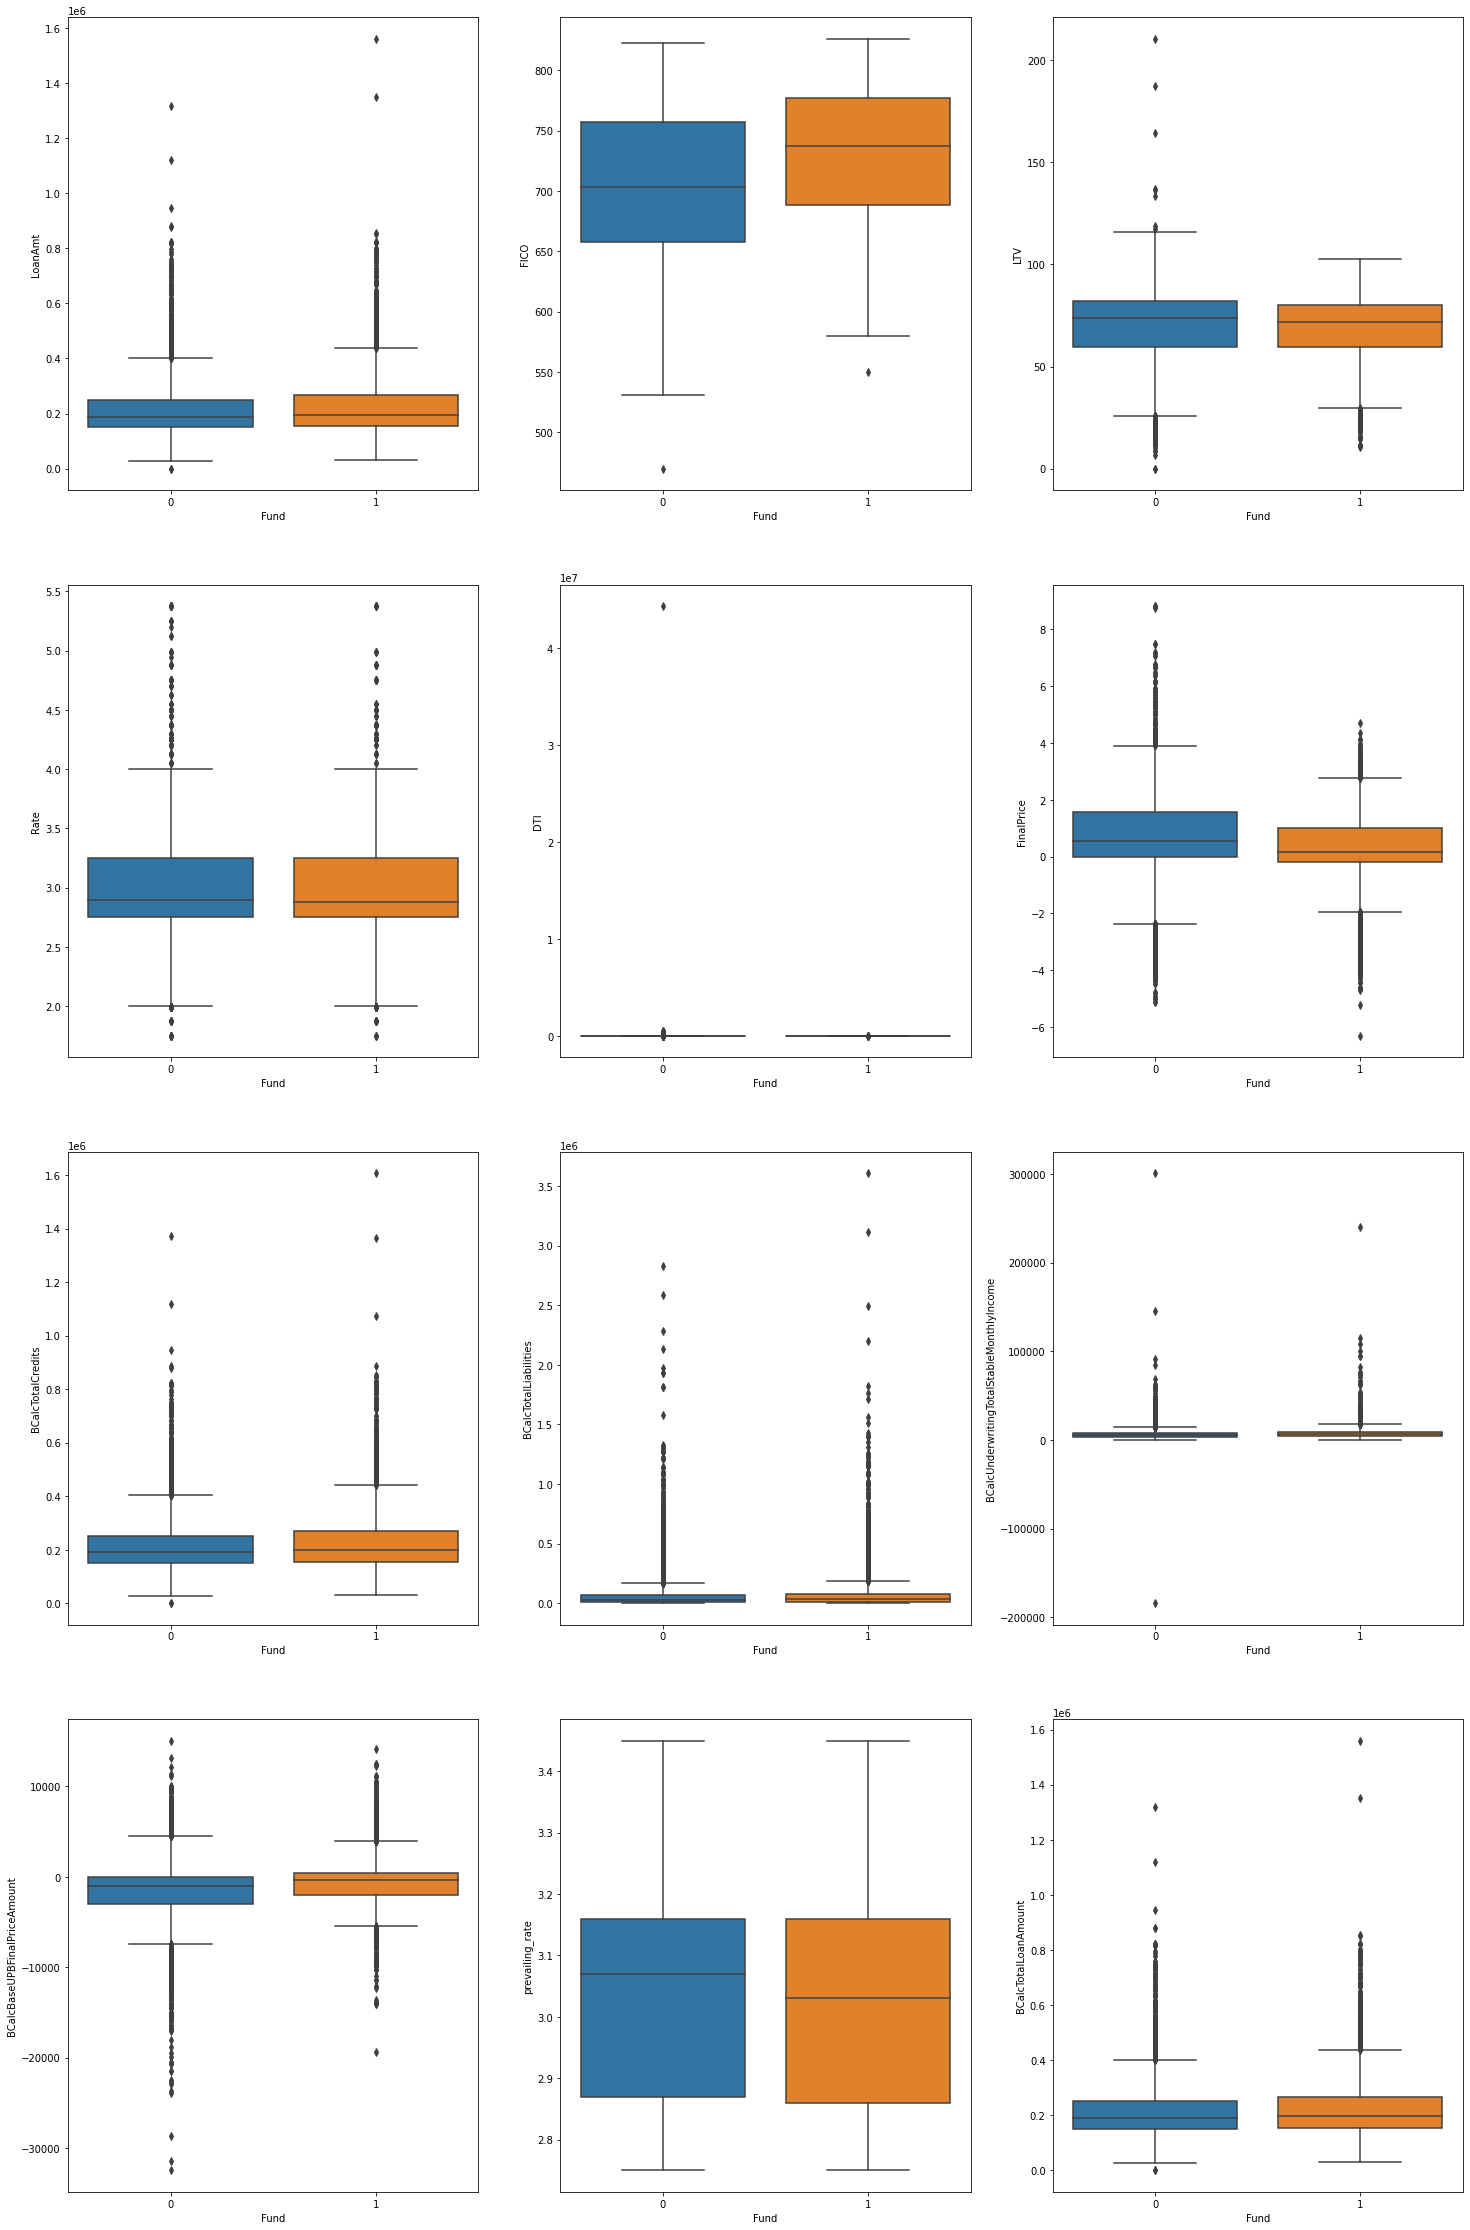

In [ ]:
#let's get boxplots of these variables
f, axes = plt.subplots(rows_float_cols, 3,figsize=(25,40))
i = 1
for col in float_cols:
    plt.subplot(rows_float_cols,3,i)
    sns.boxplot(x='Fund',y= col, data=df)
    i = i+1

<AxesSubplot:>

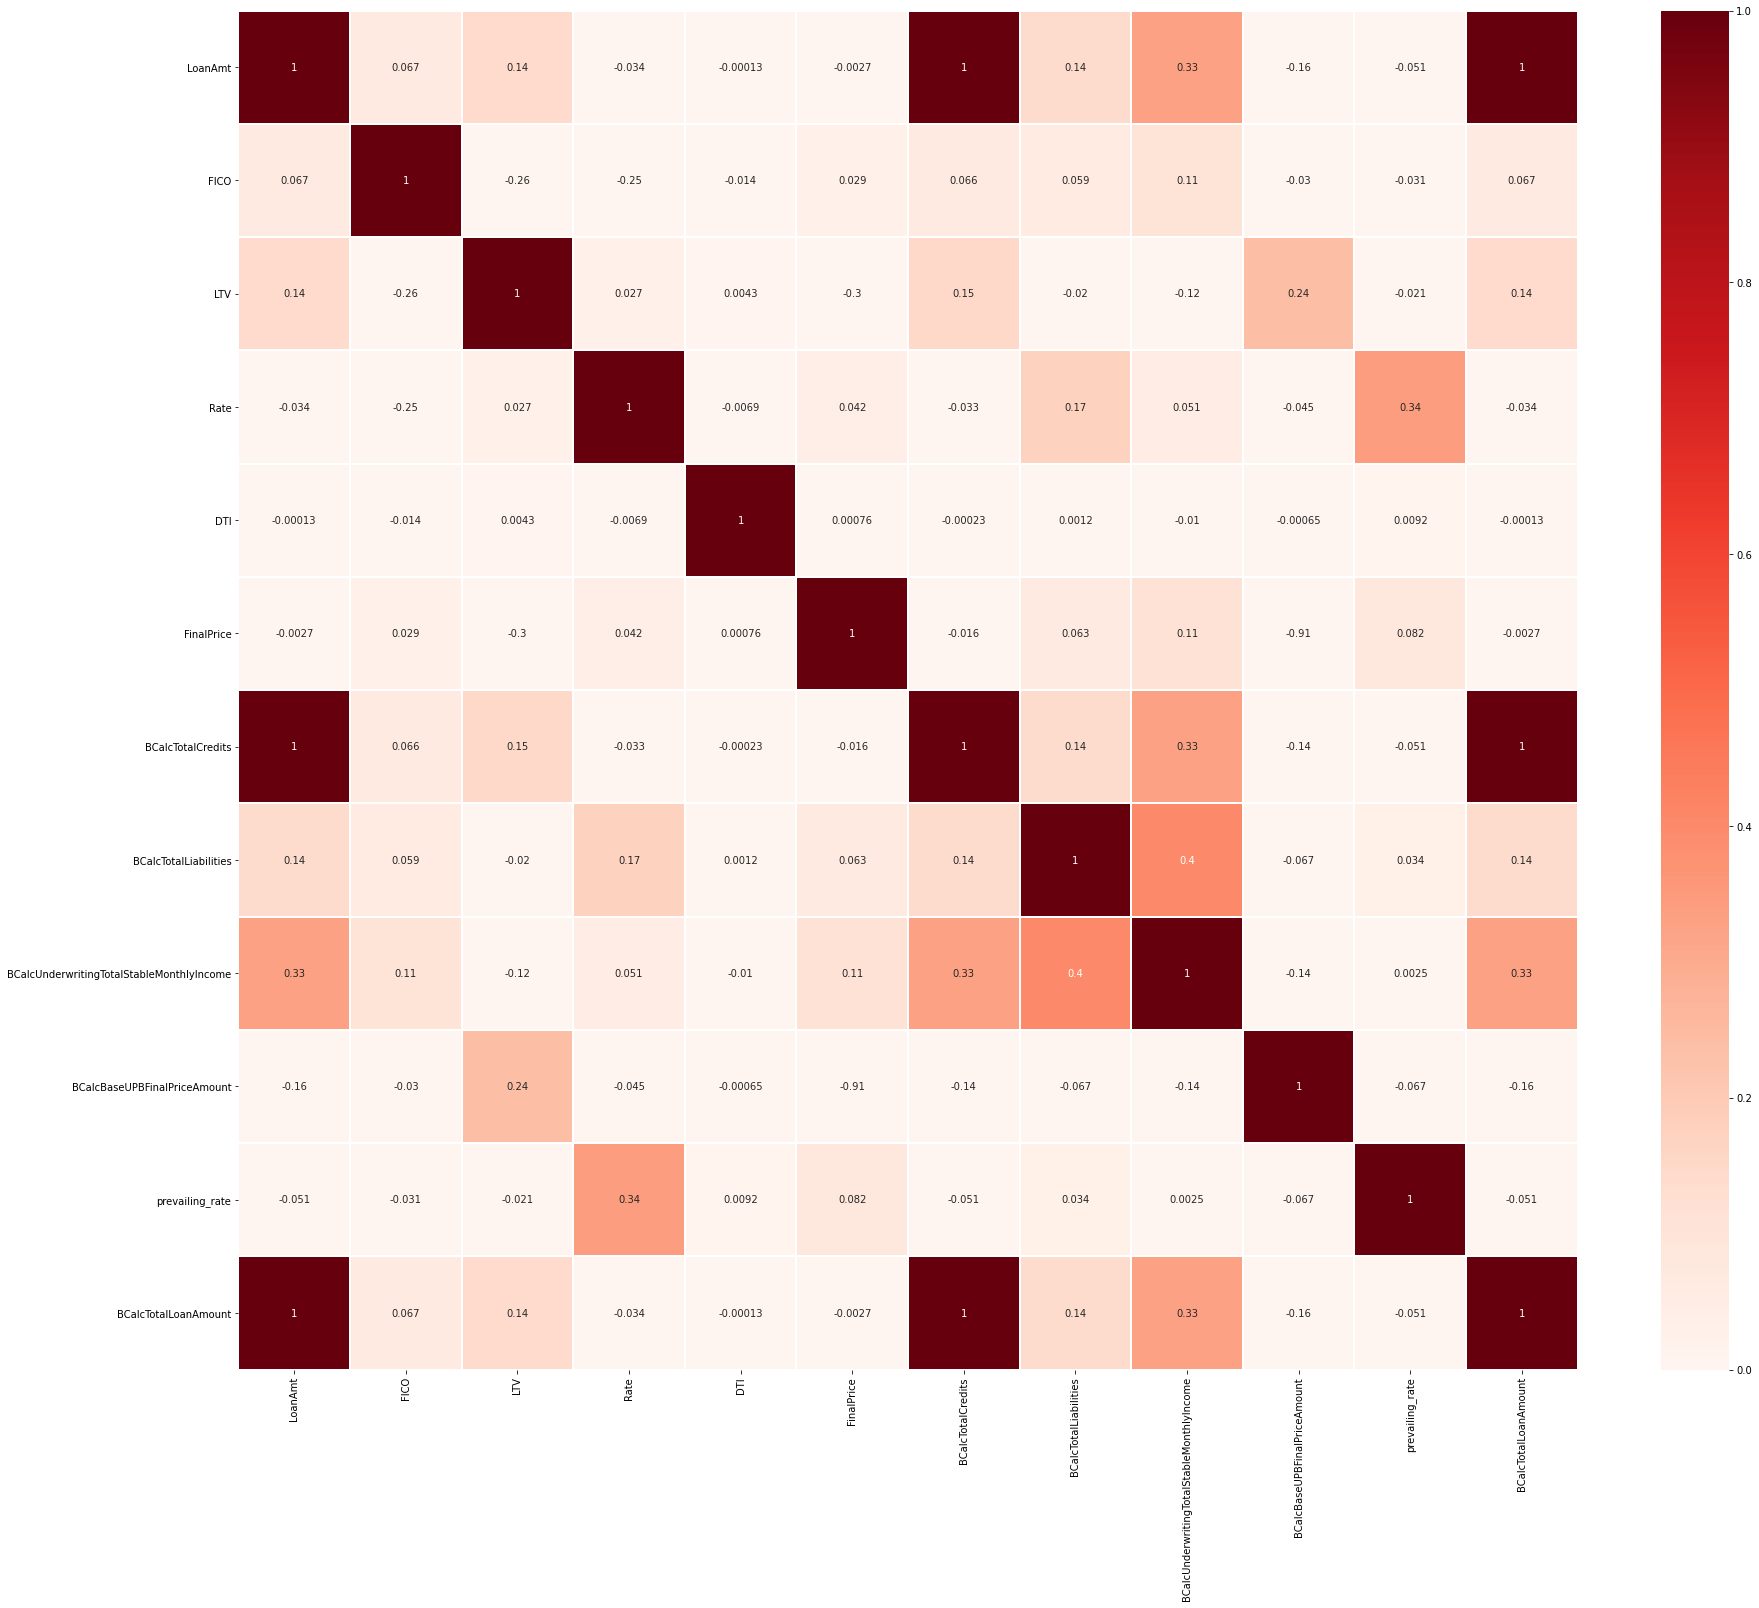

In [ ]:
#let's plot correlation map
plt.figure(figsize=(30,25))
sns.heatmap(df[float_cols].corr(),  vmin=0, vmax=1, cmap="Reds", linewidths=0.4, annot=True)

In [ ]:
#get columns who have >0.95 correlation with any of the other columns
corr_matrix = df[float_cols].corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [ ]:
to_drop

['BCalcTotalCredits', 'BCalcBaseUPBFinalPriceAmount', 'BCalcTotalLoanAmount']

In [ ]:
for col in to_drop:  
    print('drop_col : ',col)
    for column in float_cols:
        try:
            val = df[col].corr(df[column])
            if abs(val) > 0.9 and column not in to_drop:
                print(col, column,val, '\n')
        except:
            pass

drop_col :  BCalcTotalCredits
BCalcTotalCredits LoanAmt 0.998121651373952 

drop_col :  BCalcBaseUPBFinalPriceAmount
BCalcBaseUPBFinalPriceAmount FinalPrice -0.9056292921419986 

drop_col :  BCalcTotalLoanAmount
BCalcTotalLoanAmount LoanAmt 1.0 



In [ ]:
remove_cols = ['BCalcTotalCredits','BCalcTotalLoanAmount']
df.drop(remove_cols,axis=1,inplace=True)
test.drop(remove_cols,axis=1,inplace=True)
float_cols = [x for x in float_cols if x not in remove_cols]
len(float_cols)

10

In [ ]:
fund_list = [0.0,1.0]
def densityplots(df, start_col_num, end_col_num, total_cols,cols_used,target_col):
    f, ax = plt.subplots(total_cols, 1,figsize=(12,50))
    i = 1
    
    for col in cols_used[start_col_num:end_col_num]:
        plt.subplot(total_cols,1,i)
        
        for fund_value in fund_list:    
            subset = df[df[target_col]==fund_value ]         
            ax = sns.distplot(subset[col], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3},
                 rug_kws={'color': 'black'},
                 label = fund_value)
            
        i = i+1

<AxesSubplot:xlabel='Fund', ylabel='BCalcBaseUPBFinalPriceAmount'>

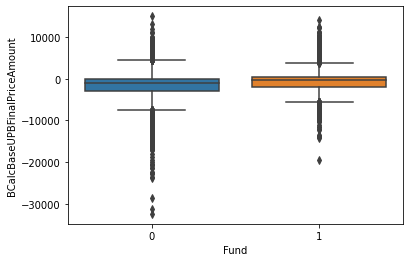

In [ ]:
sns.boxplot(x = 'Fund',y = 'BCalcBaseUPBFinalPriceAmount',data=df)

<AxesSubplot:xlabel='Fund', ylabel='FinalPrice'>

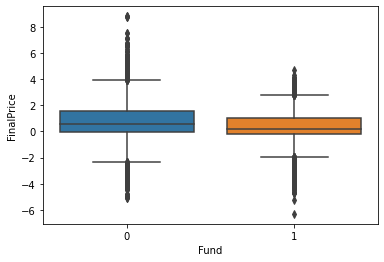

In [ ]:
sns.boxplot(x = 'Fund',y = 'FinalPrice',data=df)

In [ ]:
df['DTI'].value_counts()

 0.000000e+00    1055
 1.000000e+01      15
 4.486100e+01       5
 3.906000e+01       4
 3.198900e+01       4
 3.846300e+01       4
 3.465400e+01       4
 3.318700e+01       4
 4.395900e+01       4
 4.778800e+01       4
 4.290400e+01       4
 3.473400e+01       4
 4.358700e+01       4
 4.568400e+01       4
 4.838300e+01       4
 4.601600e+01       4
 2.969800e+01       3
 4.230200e+01       3
 4.302600e+01       3
 5.743200e+01       3
 4.386000e+01       3
 4.057300e+01       3
 4.392900e+01       3
 3.641700e+01       3
 4.353200e+01       3
 4.160500e+01       3
 4.516400e+01       3
 4.484600e+01       3
 3.326500e+01       3
 3.990000e+01       3
 2.667100e+01       3
 4.441400e+01       3
 3.136800e+01       3
 4.375300e+01       3
 3.532100e+01       3
 4.087000e+01       3
 4.424500e+01       3
 2.881100e+01       3
 4.479600e+01       3
 4.124500e+01       3
 4.490700e+01       3
 4.732800e+01       3
 3.246000e+01       3
 2.589600e+01       3
 4.895500e+01       3
 3.169400e

In [ ]:
df.shape

(12382, 26)

In [ ]:
df.head()

,LoanNumber,LoanAmt,ProductGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,RefinancePurpose,FTHBFlag,FinalPrice,NewConstructionFlag,BW1IsAVeteran,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate,Fund
0,9713036086,187500.0,CONVENTIONAL,CONVENTIONAL,FULL,360,642.0,75.000,3.625,30.682,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,TRUE,1.913,False,FALSE,18818.0,6760.87,-3586.875,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,3.14,0
1,9797657435,188000.0,CONVENTIONAL,CONVENTIONAL,FULL,180,739.0,37.228,2.750,40.096,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,FALSE,0.763,False,TRUE,40726.0,6022.00,-1434.440,DIALER BM,LENDING TREE,LEAD AGG - WARM XFER,3.14,0
2,9745002080,292000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,765.0,73.000,2.800,40.544,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,TRUE,2.135,False,FALSE,25321.0,7337.46,-6234.200,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,2.76,0
3,9757181152,181500.0,CONVENTIONAL,CONVENTIONAL,FULL,360,758.0,72.600,2.950,41.810,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,FALSE,0.810,False,FALSE,82676.0,5328.27,-1470.150,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,3.03,0
4,9740352050,125000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,796.0,39.063,3.250,31.446,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,TRUE,0.000,False,FALSE,4449.0,4692.78,0.000,BM_LEAD POINT,LEAD POINT,LEAD AGG - REAL TIME,3.07,0


In [ ]:
df['RefinancePurpose'].value_counts()

NO C/O: RATE/TERM    7765
C/O: DEBT CONSOL     3817
C/O: OTHER            203
LIMITED C/O            54
C/O: HOME IMP          32
Name: RefinancePurpose, dtype: int64

In [ ]:
df['NewConstructionFlag'].value_counts()

False    12239
True        56
Name: NewConstructionFlag, dtype: int64

In [ ]:
df.drop('NewConstructionFlag',axis=1,inplace=True)
test.drop('NewConstructionFlag',axis=1,inplace=True)
object_cols.remove('NewConstructionFlag')

In [ ]:
df['BCalcTotalLiabilities'].describe()

count    1.236000e+04
mean     7.546561e+04
std      1.595940e+05
min      0.000000e+00
25%      6.610000e+03
50%      2.911350e+04
75%      7.380850e+04
max      3.607278e+06
Name: BCalcTotalLiabilities, dtype: float64

In [ ]:
df.isnull().mean()*100

LoanNumber                                   0.000000
LoanAmt                                      0.000000
ProductGroup                                 0.000000
LoanType                                     0.000000
DocumentType                                 0.000000
AmortizationTerm                             0.000000
FICO                                         0.977225
LTV                                          0.000000
Rate                                         0.000000
DTI                                          0.000000
ResidencyType                                0.000000
PropertyType                                 0.000000
NumberOfUnits                                0.000000
RefinancePurpose                             4.126958
FTHBFlag                                     0.000000
FinalPrice                                   0.000000
BW1IsAVeteran                                0.000000
BCalcTotalLiabilities                        0.177677
BCalcUnderwritingTotalStable

In [ ]:
test['ProductGroup'].value_counts()

CONVENTIONAL           1014
FHA                     342
VA                       96
CHASE JUMBO               2
FANNIE MAE REFI NOW       1
Name: ProductGroup, dtype: int64

In [ ]:
#### remove categories of object columns which are of single digits
for col in object_cols:
    for item in df[col].value_counts().keys():
        if df[col].value_counts().get(key=item)  < 10:
            df[col] = df[col].replace(item,np.nan)
            test[col] = test[col].replace(item,np.nan)

In [ ]:
for col in object_cols:
    items = df[col].value_counts().keys()
    test_items = test[col].value_counts().keys()
    remove = [x for x in test_items if x not in items]
    for item in remove:
        test[col] = test[col].replace(item,np.nan)

In [ ]:
df['PropertyType'].value_counts()

DETACHED                11338
ATTACHED                  566
CONDOMINIUM               351
MANUFACTURED HOME         108
DETACHED CONDOMINIUM       12
Name: PropertyType, dtype: int64

In [ ]:
df['Campaign_Group'].value_counts()

NET THEOREM            5567
OTHER                  1008
WEBSITE                 672
ICONIC RESULTS          635
ASSURANCE               608
CONVERSION KING         584
UNATTRIBUTED            581
ILG                     481
LEAD POINT              429
LENDING TREE            405
PAST CUSTOMER           340
DIALER                  225
CREDIT TRIGGERS          91
EXL SERVICE              90
SUITED CONNECTOR         83
SERVICING XFER           80
ACQUISITION              64
REAL TIME LEADS          56
BENEFIT                  51
THIRD PARTY DM           48
GENERAL QUICK QUOTE      43
ADHOC BLAST              40
BELO                     35
RGR MARKETING            34
SHARK TANK               22
PX                       20
JORNAYA ACTIVATE         11
UNKNOWN                  10
DIGITAL MARKETING        10
Name: Campaign_Group, dtype: int64

In [ ]:
df.loc[((df['FICO'].isnull()) & (df['DocumentType']=='STREAMLINE')),'FICO'] = 680
test.loc[((test['FICO'].isnull()) & (test['DocumentType']=='STREAMLINE')),'FICO'] = 680
for col in float_cols:
    val = df[col].mean()
    df[col] = df[col].replace(np.nan,val)
    test[col] = test[col].replace(np.nan,val)

In [ ]:
for col in object_cols:
    val = df[col].mode()[0]
    df[col] = df[col].replace(np.nan,val)
    test[col] = test[col].replace(np.nan,val)

In [ ]:
df.isnull().sum()

LoanNumber                                   0
LoanAmt                                      0
ProductGroup                                 0
LoanType                                     0
DocumentType                                 0
AmortizationTerm                             0
FICO                                         0
LTV                                          0
Rate                                         0
DTI                                          0
ResidencyType                                0
PropertyType                                 0
NumberOfUnits                                0
RefinancePurpose                             0
FTHBFlag                                     0
FinalPrice                                   0
BW1IsAVeteran                                0
BCalcTotalLiabilities                        0
BCalcUnderwritingTotalStableMonthlyIncome    0
BCalcBaseUPBFinalPriceAmount                 0
AttributedCampaignCategory                   0
Campaign_Grou

In [ ]:
df['Fund'].value_counts(normalize=True)*100

0    62.978517
1    37.021483
Name: Fund, dtype: float64

In [ ]:
df.head()

,LoanNumber,LoanAmt,ProductGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,RefinancePurpose,FTHBFlag,FinalPrice,BW1IsAVeteran,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate,Fund
0,9713036086,187500.0,CONVENTIONAL,CONVENTIONAL,FULL,360,642.0,75.000,3.625,30.682,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,TRUE,1.913,FALSE,18818.0,6760.87,-3586.875,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,3.14,0
1,9797657435,188000.0,CONVENTIONAL,CONVENTIONAL,FULL,180,739.0,37.228,2.750,40.096,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,FALSE,0.763,TRUE,40726.0,6022.00,-1434.440,DIALER BM,LENDING TREE,LEAD AGG - WARM XFER,3.14,0
2,9745002080,292000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,765.0,73.000,2.800,40.544,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,TRUE,2.135,FALSE,25321.0,7337.46,-6234.200,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,2.76,0
3,9757181152,181500.0,CONVENTIONAL,CONVENTIONAL,FULL,360,758.0,72.600,2.950,41.810,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,FALSE,0.810,FALSE,82676.0,5328.27,-1470.150,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,3.03,0
4,9740352050,125000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,796.0,39.063,3.250,31.446,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,TRUE,0.000,FALSE,4449.0,4692.78,0.000,BM_LEAD POINT,LEAD POINT,LEAD AGG - REAL TIME,3.07,0


In [ ]:
#train and test set splitting
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df, stratify=df['Fund'], test_size=0.2, random_state = 10)

In [ ]:
df_train.shape, df_test.shape

((9905, 25), (2477, 25))

In [ ]:
df_train_ohc = df_train.copy(deep=True)
df_test_ohc = df_test.copy(deep=True)
df_val_ohc = test.copy(deep=True)

In [ ]:
df_train.head()

,LoanNumber,LoanAmt,ProductGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,RefinancePurpose,FTHBFlag,FinalPrice,BW1IsAVeteran,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate,Fund
5323,9710736241,548000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,794.0,51.456,2.875,35.600,PRIMARY RESIDENCE,DETACHED,1,NO C/O: RATE/TERM,TRUE,-0.114,FALSE,16098.0,13812.1100,624.72,COLA,OTHER,OTHER,2.83,1
9795,9720156836,211000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,671.0,76.728,3.750,18.821,PRIMARY RESIDENCE,DETACHED,1,NO C/O: RATE/TERM,FALSE,0.834,FALSE,135777.0,17839.0600,-1759.74,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,3.14,1
8338,9727547110,312000.0,VA,VA,STREAMLINE,360,698.0,98.846,2.250,45.684,PRIMARY RESIDENCE,DETACHED,1,NO C/O: RATE/TERM,FALSE,0.000,TRUE,27971.0,4733.8667,0.00,UNATTRIBUTED,UNATTRIBUTED,UNATTRIBUTED,2.84,0
1548,9793810087,227550.0,CONVENTIONAL,CONVENTIONAL,FULL,120,782.0,40.634,2.500,20.513,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,FALSE,0.000,FALSE,61647.0,20293.4400,0.00,BM_NETTHEOREM LEAD,NET THEOREM,LEAD AGG - WARM XFER,2.80,1
5750,9793829533,180000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,739.0,79.296,2.875,28.352,PRIMARY RESIDENCE,DETACHED,1,NO C/O: RATE/TERM,FALSE,-0.005,FALSE,18793.0,10000.0000,9.00,UNATTRIBUTED,UNATTRIBUTED,UNATTRIBUTED,2.80,0


In [ ]:
def calc_smooth_mean(df, by, on, m):
    mean = df[on].mean()
    agg = df.groupby(by)[on].agg(['count','mean'])
    counts = agg['count']
    means = agg['mean']
    smooth = (counts*means+m*mean)/(counts+m)
    return smooth

In [ ]:
# Target Encoding for categorical variables
for col in object_cols:
    smooth = calc_smooth_mean(df_train,col,'Fund',1000)
    df_train[col] = df_train[col].map(smooth*100)
    df_test[col] = df_test[col].map(smooth*100)
    test[col] = test[col].map(smooth*100)

## One Hot Encoding

In [ ]:
df_train_ohc[object_cols].head()

,ProductGroup,LoanType,DocumentType,ResidencyType,PropertyType,RefinancePurpose,FTHBFlag,AttributedCampaignCategory,Campaign_Group,Marketing_Group,BW1IsAVeteran
5323,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,NO C/O: RATE/TERM,TRUE,COLA,OTHER,OTHER,FALSE
9795,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,NO C/O: RATE/TERM,FALSE,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,FALSE
8338,VA,VA,STREAMLINE,PRIMARY RESIDENCE,DETACHED,NO C/O: RATE/TERM,FALSE,UNATTRIBUTED,UNATTRIBUTED,UNATTRIBUTED,TRUE
1548,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,C/O: DEBT CONSOL,FALSE,BM_NETTHEOREM LEAD,NET THEOREM,LEAD AGG - WARM XFER,FALSE
5750,CONVENTIONAL,CONVENTIONAL,FULL,PRIMARY RESIDENCE,DETACHED,NO C/O: RATE/TERM,FALSE,UNATTRIBUTED,UNATTRIBUTED,UNATTRIBUTED,FALSE


In [ ]:
for col in object_cols:
    print(col, df_train_ohc[col].nunique())

ProductGroup 3
LoanType 3
DocumentType 2
ResidencyType 3
PropertyType 5
RefinancePurpose 5
FTHBFlag 2
AttributedCampaignCategory 32
Campaign_Group 29
Marketing_Group 19
BW1IsAVeteran 2


In [ ]:
#making dummy variables for all the columns
onehot_object_cols = object_cols
onehot_object_cols.remove('AttributedCampaignCategory')
onehot_object_cols.remove('Campaign_Group')
onehot_object_cols.remove('Marketing_Group')

In [ ]:
for i in onehot_object_cols:
    s = pd.get_dummies(df_train_ohc[i],prefix=i,drop_first = False)         # get dummies for the categorical variables and concat to X
    df_train_ohc = pd.concat([df_train_ohc,s], axis = 1)
    t = pd.get_dummies(df_test_ohc[i],prefix=i,drop_first = False)         # get dummies for the categorical variables and concat to X
    df_test_ohc = pd.concat([df_test_ohc,t], axis = 1)
    u = pd.get_dummies(df_val_ohc[i],prefix=i,drop_first = False)         # get dummies for the categorical variables and concat to X
    df_val_ohc = pd.concat([df_val_ohc,u], axis = 1)
print(df_train_ohc.shape)
print(df_test_ohc.shape)
print(df_val_ohc.shape)

(9905, 50)
(2477, 50)
(1455, 48)


In [ ]:
df_val_ohc.head()

,LoanNumber,LoanAmt,ProductGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,RefinancePurpose,FTHBFlag,FinalPrice,BW1IsAVeteran,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate,ProductGroup_CONVENTIONAL,ProductGroup_FHA,ProductGroup_VA,LoanType_CONVENTIONAL,LoanType_FHA,LoanType_VA,DocumentType_FULL,DocumentType_STREAMLINE,ResidencyType_INVESTMENT PROPERTY,ResidencyType_PRIMARY RESIDENCE,ResidencyType_SECONDARY RESIDENCE,PropertyType_ATTACHED,PropertyType_CONDOMINIUM,PropertyType_DETACHED,PropertyType_MANUFACTURED HOME,RefinancePurpose_C/O: DEBT CONSOL,RefinancePurpose_C/O: HOME IMP,RefinancePurpose_C/O: OTHER,RefinancePurpose_LIMITED C/O,RefinancePurpose_NO C/O: RATE/TERM,FTHBFlag_FALSE,FTHBFlag_TRUE,BW1IsAVeteran_FALSE,BW1IsAVeteran_TRUE
0,9761370643,269000.0,CONVENTIONAL,CONVENTIONAL,FULL,360,774.0,74.723,3.990,23.290,INVESTMENT PROPERTY,DETACHED,1,C/O: HOME IMP,FALSE,1.743,FALSE,570807.0,10000.00,-4688.6700,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,3.21,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
1,9774670526,256400.0,CONVENTIONAL,CONVENTIONAL,FULL,240,725.0,54.554,2.850,60.321,PRIMARY RESIDENCE,DETACHED,1,NO C/O: RATE/TERM,FALSE,0.788,FALSE,377412.0,9697.04,-2020.4320,UNKNOWN,OTHER,OTHER,3.24,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0
2,9773394730,259462.0,FHA,FHA,FULL,360,605.0,78.462,2.650,54.369,PRIMARY RESIDENCE,DETACHED,1,C/O: DEBT CONSOL,TRUE,2.601,FALSE,132493.0,6416.80,-6748.6066,BM_LEAD POINT,LEAD POINT,LEAD AGG - WARM XFER,3.07,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0
3,9737214560,103500.0,CONVENTIONAL,CONVENTIONAL,FULL,360,793.0,29.572,3.125,33.887,SECONDARY RESIDENCE,DETACHED,1,NO C/O: RATE/TERM,TRUE,-0.010,FALSE,114263.0,5514.02,10.3500,ADHOC,OTHER,DM MARKETING,3.16,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0
4,9752609322,348642.0,FHA,FHA,STREAMLINE,360,680.0,85.662,3.000,0.000,PRIMARY RESIDENCE,DETACHED,1,NO C/O: RATE/TERM,FALSE,-1.292,FALSE,0.0,0.00,4504.4546,BM_NETTHEOREM,NET THEOREM,THIRD PARTY DM,3.21,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0


In [ ]:
df_train_ohc = df_train_ohc[list(set(df_train_ohc.columns)-set(df_train.columns))+['LoanNumber']]
df_test_ohc = df_test_ohc[list(set(df_test_ohc.columns)-set(df_test.columns))+['LoanNumber']]
df_val_ohc = df_val_ohc[list(set(df_val_ohc.columns)-set(test.columns))+['LoanNumber']]

In [ ]:
print(df_train_ohc.shape)
print(df_test_ohc.shape)
print(df_val_ohc.shape)

(9905, 26)
(2477, 26)
(1455, 25)


In [ ]:
for col in df_test_ohc.columns:
    if col not in df_val_ohc.columns:
        df_val_ohc[col] = 0
df_val_ohc = df_val_ohc[df_test_ohc.columns]

In [ ]:
df_train_ohc.columns == df_test_ohc.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
df_train_ohc.columns == df_val_ohc.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [ ]:
df_train_ohc.head()

,PropertyType_DETACHED CONDOMINIUM,FTHBFlag_TRUE,PropertyType_ATTACHED,RefinancePurpose_C/O: OTHER,RefinancePurpose_C/O: HOME IMP,DocumentType_FULL,ProductGroup_FHA,ProductGroup_VA,LoanType_VA,ResidencyType_INVESTMENT PROPERTY,ProductGroup_CONVENTIONAL,ResidencyType_SECONDARY RESIDENCE,BW1IsAVeteran_FALSE,RefinancePurpose_NO C/O: RATE/TERM,LoanType_FHA,BW1IsAVeteran_TRUE,RefinancePurpose_C/O: DEBT CONSOL,RefinancePurpose_LIMITED C/O,PropertyType_DETACHED,PropertyType_CONDOMINIUM,DocumentType_STREAMLINE,PropertyType_MANUFACTURED HOME,LoanType_CONVENTIONAL,FTHBFlag_FALSE,ResidencyType_PRIMARY RESIDENCE,LoanNumber
5323,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1,9710736241
9795,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,9720156836
8338,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1,9727547110
1548,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,1,1,9793810087
5750,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1,9793829533


In [ ]:
df_test_ohc = df_test_ohc[df_train_ohc.columns]
df_val_ohc = df_val_ohc[df_train_ohc.columns]

In [ ]:
df_train_final = pd.merge(df_train,df_train_ohc,how='left',on='LoanNumber')
df_test_final = pd.merge(df_test,df_test_ohc,how='left',on='LoanNumber')
df_val_final = pd.merge(test,df_val_ohc,how='left',on='LoanNumber')

In [ ]:
df_train_final.head()

,LoanNumber,LoanAmt,ProductGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,RefinancePurpose,FTHBFlag,FinalPrice,BW1IsAVeteran,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate,Fund,PropertyType_DETACHED CONDOMINIUM,FTHBFlag_TRUE,PropertyType_ATTACHED,RefinancePurpose_C/O: OTHER,RefinancePurpose_C/O: HOME IMP,DocumentType_FULL,ProductGroup_FHA,ProductGroup_VA,LoanType_VA,ResidencyType_INVESTMENT PROPERTY,ProductGroup_CONVENTIONAL,ResidencyType_SECONDARY RESIDENCE,BW1IsAVeteran_FALSE,RefinancePurpose_NO C/O: RATE/TERM,LoanType_FHA,BW1IsAVeteran_TRUE,RefinancePurpose_C/O: DEBT CONSOL,RefinancePurpose_LIMITED C/O,PropertyType_DETACHED,PropertyType_CONDOMINIUM,DocumentType_STREAMLINE,PropertyType_MANUFACTURED HOME,LoanType_CONVENTIONAL,FTHBFlag_FALSE,ResidencyType_PRIMARY RESIDENCE
0,9710736241,548000.0,41.141350,41.157620,38.555162,360,794.0,51.456,2.875,35.600,36.410371,36.773593,1,36.467579,37.124112,-0.114,37.299052,16098.0,13812.1100,624.72,44.735271,46.923598,46.592259,2.83,1,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1
1,9720156836,211000.0,41.141350,41.157620,38.555162,360,671.0,76.728,3.750,18.821,36.410371,36.773593,1,36.467579,36.936812,0.834,37.299052,135777.0,17839.0600,-1759.74,36.168030,33.064650,33.331099,3.14,1,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1
2,9727547110,312000.0,36.772829,36.796029,32.395987,360,698.0,98.846,2.250,45.684,36.410371,36.773593,1,36.467579,36.936812,0.000,35.646500,27971.0,4733.8667,0.00,37.889796,39.344532,39.344532,2.84,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1
3,9793810087,227550.0,41.141350,41.157620,38.555162,120,782.0,40.634,2.500,20.513,36.410371,36.773593,1,36.416264,36.936812,0.000,37.299052,61647.0,20293.4400,0.00,35.624868,33.064650,28.819603,2.80,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,1,1
4,9793829533,180000.0,41.141350,41.157620,38.555162,360,739.0,79.296,2.875,28.352,36.410371,36.773593,1,36.467579,36.936812,-0.005,37.299052,18793.0,10000.0000,9.00,37.889796,39.344532,39.344532,2.80,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1


In [ ]:
print(df_train_final.shape)
print(df_test_final.shape)
print(df_val_final.shape)

(9905, 50)
(2477, 50)
(1455, 49)


In [ ]:
X_train = df_train_final.drop(['LoanNumber','Fund'],axis=1)
X_test = df_test_final.drop(['LoanNumber','Fund'],axis=1)
X_val = df_val_final.drop('LoanNumber',axis=1)
y_train = df_train_final['Fund']
y_test = df_test_final['Fund']

In [ ]:
X_train.head()

,LoanAmt,ProductGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,RefinancePurpose,FTHBFlag,FinalPrice,BW1IsAVeteran,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate,PropertyType_DETACHED CONDOMINIUM,FTHBFlag_TRUE,PropertyType_ATTACHED,RefinancePurpose_C/O: OTHER,RefinancePurpose_C/O: HOME IMP,DocumentType_FULL,ProductGroup_FHA,ProductGroup_VA,LoanType_VA,ResidencyType_INVESTMENT PROPERTY,ProductGroup_CONVENTIONAL,ResidencyType_SECONDARY RESIDENCE,BW1IsAVeteran_FALSE,RefinancePurpose_NO C/O: RATE/TERM,LoanType_FHA,BW1IsAVeteran_TRUE,RefinancePurpose_C/O: DEBT CONSOL,RefinancePurpose_LIMITED C/O,PropertyType_DETACHED,PropertyType_CONDOMINIUM,DocumentType_STREAMLINE,PropertyType_MANUFACTURED HOME,LoanType_CONVENTIONAL,FTHBFlag_FALSE,ResidencyType_PRIMARY RESIDENCE
0,548000.0,41.141350,41.157620,38.555162,360,794.0,51.456,2.875,35.600,36.410371,36.773593,1,36.467579,37.124112,-0.114,37.299052,16098.0,13812.1100,624.72,44.735271,46.923598,46.592259,2.83,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,1
1,211000.0,41.141350,41.157620,38.555162,360,671.0,76.728,3.750,18.821,36.410371,36.773593,1,36.467579,36.936812,0.834,37.299052,135777.0,17839.0600,-1759.74,36.168030,33.064650,33.331099,3.14,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1
2,312000.0,36.772829,36.796029,32.395987,360,698.0,98.846,2.250,45.684,36.410371,36.773593,1,36.467579,36.936812,0.000,35.646500,27971.0,4733.8667,0.00,37.889796,39.344532,39.344532,2.84,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,1,1
3,227550.0,41.141350,41.157620,38.555162,120,782.0,40.634,2.500,20.513,36.410371,36.773593,1,36.416264,36.936812,0.000,37.299052,61647.0,20293.4400,0.00,35.624868,33.064650,28.819603,2.80,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,1,1
4,180000.0,41.141350,41.157620,38.555162,360,739.0,79.296,2.875,28.352,36.410371,36.773593,1,36.467579,36.936812,-0.005,37.299052,18793.0,10000.0000,9.00,37.889796,39.344532,39.344532,2.80,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,0,1,1,1


## Random Forest

In [ ]:

from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
# random forest model creation
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
X_test.isnull().mean()*100

LoanAmt                                      0.0
ProductGroup                                 0.0
LoanType                                     0.0
DocumentType                                 0.0
AmortizationTerm                             0.0
FICO                                         0.0
LTV                                          0.0
Rate                                         0.0
DTI                                          0.0
ResidencyType                                0.0
PropertyType                                 0.0
NumberOfUnits                                0.0
RefinancePurpose                             0.0
FTHBFlag                                     0.0
FinalPrice                                   0.0
BW1IsAVeteran                                0.0
BCalcTotalLiabilities                        0.0
BCalcUnderwritingTotalStableMonthlyIncome    0.0
BCalcBaseUPBFinalPriceAmount                 0.0
AttributedCampaignCategory                   0.0
Campaign_Group      

In [ ]:
# predictions
rfc_predict = rfc.predict_proba(X_test)
rfc_val = rfc.predict_proba(X_val)

In [ ]:
rfc_predict[0:5]

array([[0.85, 0.15],
       [0.79, 0.21],
       [0.65, 0.35],
       [0.49, 0.51],
       [0.85, 0.15]])

In [ ]:
probs_rfc_test = rfc_predict[:,1]
probs_rfc_val = rfc_val[:,1]
probs_rfc_test[0:5]

array([0.15, 0.21, 0.35, 0.51, 0.15])

In [ ]:
np.shape(df_test_final), np.shape(y_test), np.shape(probs_rfc_test), np.shape(df_val_final), np.shape(probs_rfc_val)

((2477, 50), (2477,), (2477,), (1455, 49), (1455,))

In [ ]:
predictions_rfc_test = pd.DataFrame({'LoanNumber': df_test_final['LoanNumber'], 'Fund':y_test, 'prob': probs_rfc_test})
# Sort on prediction (descending)
predictions_rfc_test = predictions_rfc_test.sort_values(by = 'prob',ascending=False)
predictions_rfc_test.head()

,LoanNumber,Fund,prob
2234,9711329756,1,0.95
633,9793277980,1,0.92
596,9792768369,1,0.91
1182,9716212874,1,0.91
754,9774755178,0,0.90


In [ ]:
predictions_val = pd.DataFrame({'LoanNumber': df_val_final['LoanNumber'], 'prob_rf': probs_rfc_val})

In [ ]:
data_test = predictions_rfc_test.copy()
data_test.shape

(2477, 3)

In [ ]:
def get_gains(data,target_col):
    
    data['row_id'] = range(0,0+len(data))  # Add row ids
    data['decile'] = ( data['row_id'] / (len(data)/10) ).astype(int) # Add decile
    #data.head()
    
    # Check the count by decile
    data.loc[data['decile'] == 10]=9
    data['decile'].value_counts()
    
    #create gains table
    data['decile'] = data['decile']+1
    gains = data.groupby('decile')[target_col,'STU_Flag'].agg(['count','sum']).reset_index()
    gains.columns = ['decile','count','actual_funds','count_STU','STU']
    gains.drop('count_STU',axis=1,inplace=True)
    gains['%STU'] = (gains['STU']/gains['count']).round(2)
    gains['%actual_funds'] = (gains['actual_funds']/gains['count']).round(2)
    
    #add metrics to the gains table
    gains['non_actual_funds'] = gains['count'] - gains['actual_funds']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual_funds'].cumsum()
    gains['cum_non_actual'] = gains['non_actual_funds'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual'] ) * 100
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains = pd.DataFrame(gains)
    gains = gains[['decile', 'count', 'actual_funds', '%actual_funds','STU', '%STU', 'non_actual_funds',
       'cum_count', 'cum_actual', 'cum_non_actual', 'percent_cum_actual',
       'percent_cum_non_actual', 'if_random', 'K_S', 'lift']]
    return gains

In [ ]:
gains_stats = get_gains(data_test,'Fund')
gains_stats

,decile,count,actual_funds,%actual_funds,STU,%STU,non_actual_funds,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,248,189,0.76,232,0.94,59,248,189,59,0.21,0.04,91.7,17.0,2.06
1,2,248,161,0.65,210,0.85,87,496,350,146,0.38,0.09,183.4,29.0,1.91
2,3,248,140,0.56,197,0.79,108,744,490,254,0.53,0.16,275.1,37.0,1.78
3,4,247,112,0.45,175,0.71,135,991,602,389,0.66,0.25,366.8,41.0,1.64
4,5,248,99,0.40,161,0.65,149,1239,701,538,0.76,0.34,458.5,42.0,1.53
5,6,248,93,0.38,149,0.60,155,1487,794,693,0.87,0.44,550.2,43.0,1.44
6,7,247,52,0.21,139,0.56,195,1734,846,888,0.92,0.57,641.9,35.0,1.32
7,8,248,43,0.17,119,0.48,205,1982,889,1093,0.97,0.70,733.6,27.0,1.21
8,9,248,24,0.10,104,0.42,224,2230,913,1317,1.00,0.84,825.3,16.0,1.11
9,10,247,4,0.02,119,0.48,243,2477,917,1560,1.00,1.00,917.0,0.0,1.00


In [ ]:
predictions_rfc_test.head()

,LoanNumber,Fund,prob
2234,9711329756,1,0.95
633,9793277980,1,0.92
596,9792768369,1,0.91
1182,9716212874,1,0.91
754,9774755178,0,0.90


In [ ]:
import scikitplot as skplt
def gain_plot(y,probs):
    
    final_prob_df  = pd.DataFrame({'0': 1-probs,'1':probs})
    
    skplt.metrics.plot_cumulative_gain(y,final_prob_df)
    plt.show()

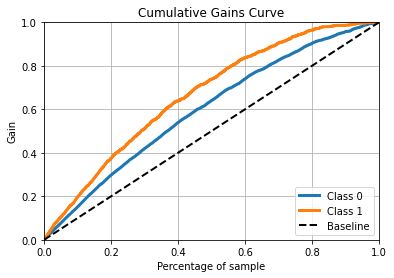

In [ ]:
gain_plot(y_test,probs_rfc_test)

In [ ]:
from sklearn.metrics import roc_curve, auc

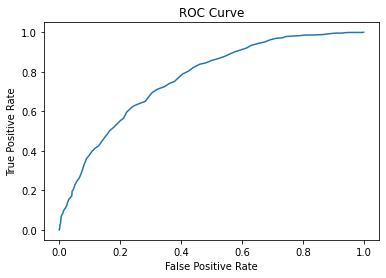

In [ ]:
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, probs_rfc_test)
plt.plot(fpr_lgb, tpr_lgb)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
roc_auc_score(y_test,probs_rfc_test, average='macro')

0.7648973799737159

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
#rfc_cv_score = cross_val_score(rfc, X_train, y_train, cv=10, scoring='roc_auc')

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(predictions_rfc_test['Fund'], predictions_rfc_test['prob'])

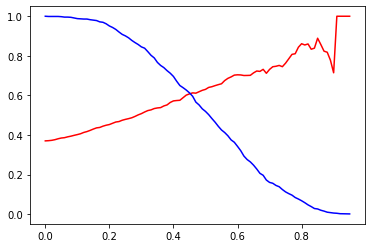

In [ ]:
plt.plot(thresholds, precision[:-1], "r-")
plt.plot(thresholds, recall[:-1], "b-")
plt.show()

In [ ]:
rfc_predict = np.where(probs_rfc_test > 0.43, 1, 0)
rfc_predict[0:5]

array([0, 0, 0, 1, 0])

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_test,rfc_predict, average='weighted')

0.7093061282507974

In [ ]:
print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict))
print('\n')
# print("=== All AUC Scores ===")
# print(rfc_cv_score)
# print('\n')
# print("=== Mean AUC Score ===")
# #print("Mean AUC Score - Random Forest: ", rfc_cv_score.mean())

=== Confusion Matrix ===
[[1179  381]
 [ 342  575]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      1560
           1       0.60      0.63      0.61       917

    accuracy                           0.71      2477
   macro avg       0.69      0.69      0.69      2477
weighted avg       0.71      0.71      0.71      2477





### LightGBM

In [ ]:
X_train = df_train.drop(['LoanNumber','Fund'],axis=1)
X_test = df_test.drop(['LoanNumber','Fund'],axis=1)
X_val = test.drop('LoanNumber',axis=1)
y_train = df_train['Fund']
y_test = df_test['Fund']

In [ ]:
X_train.shape, X_val.shape

((9905, 23), (1455, 23))

In [ ]:
df_train_lgb = X_train
y_train_lgb = np.array(y_train)

In [ ]:
df_test_lgb = X_test
df_val_lgb = X_val

In [ ]:
random_seed = 12345

In [ ]:
#for encoded version
train_data = lgb.Dataset(data = df_train_lgb, label = y_train_lgb)

def lgb_eval(num_iterations,num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight,learning_rate,min_data_in_leaf,bagging_freq):
    params = {'application':'binary', 'learning_rate':0.01, 'early_stopping_round':100, 'metric':'auc'} #f_roc_auc for roc_auc
    params['num_iterations'] = int(num_iterations)
    params["num_leaves"] = int(round(num_leaves))
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = int(round(max_depth))
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight
    params['learning_rate'] = learning_rate
    params['min_data_in_leaf'] = int(round(min_data_in_leaf))
    params['bagging_freq'] = int(round(bagging_freq))
    cv_result = lgb.cv(params, train_data, nfold=10, seed=random_seed, stratified=True, verbose_eval =200, metrics = ['auc']) #feval = f_roc_auc for roc_auc isntead of metrics = ['auc']
    return max(cv_result['auc-mean'])

In [ ]:
from bayes_opt import BayesianOptimization
lgbBO = BayesianOptimization(lgb_eval, {'num_iterations': (10,5000),
                                        'num_leaves': (24, 45),
                                        'feature_fraction': (0.1, 0.9),
                                        'bagging_fraction': (0.8, 1),
                                        'max_depth': (5, 8.99),
                                        'lambda_l1': (0, 5),
                                        'lambda_l2': (0, 3),
                                        'min_split_gain': (0.001, 0.1),
                                        'min_child_weight': (5, 50), 
                                        'learning_rate' : (0,1),
                                        'min_data_in_leaf' : (50,200),
                                        'bagging_freq' : (1,10)}, random_state=0)

In [ ]:
parameters = {'bagging_fraction': 0.909762700785465,
 'bagging_freq': 7.436704297351775,
 'feature_fraction': 0.5822107008573151,
 'lambda_l1': 2.724415914984484,
 'lambda_l2': 1.270964398016714,
 'learning_rate': 0.6458941130666561,
 'max_depth': 6.7459729729381435,
 'min_child_weight': 45.12978503519359,
 'min_data_in_leaf': 194.5494140751544,
 'min_split_gain': 0.038960710363751996,
 'num_iterations': 3960.7079400324965,
 'num_leaves': 35.10679331481099}

In [ ]:
parameters['num_iterations']

3960.7079400324965

In [ ]:
parameters

{'bagging_fraction': 0.909762700785465,
 'bagging_freq': 7.436704297351775,
 'feature_fraction': 0.5822107008573151,
 'lambda_l1': 2.724415914984484,
 'lambda_l2': 1.270964398016714,
 'learning_rate': 0.6458941130666561,
 'max_depth': 6.7459729729381435,
 'min_child_weight': 45.12978503519359,
 'min_data_in_leaf': 194.5494140751544,
 'min_split_gain': 0.038960710363751996,
 'num_iterations': 3960.7079400324965,
 'num_leaves': 35.10679331481099}

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc

In [ ]:
lgb_auc_score = []
# preds_lgb_train = []
preds_lgb_test = []
preds_lgb_val = []
preds_lgb_train = []

lgbfold=StratifiedKFold(n_splits=10, random_state=12345, shuffle=True)
i = 1
print(f"Seed: {random_seed}")
for train_idx, val_idx in lgbfold.split(df_train_lgb, y_train_lgb):
    X_train_train_lgb, X_val_train_lgb = df_train_lgb.iloc[train_idx], df_train_lgb.iloc[val_idx]
    y_train_train_lgb, y_val_train_lgb = y_train_lgb[train_idx], y_train_lgb[val_idx]
    
    params = {
     "objective" : "binary",
     "num_iterations" : int(parameters['num_iterations']),
     "metric" : "auc", #for auc
     "max_depth" : int(round(parameters['max_depth'])),
     "learning_rate" : parameters['learning_rate'],
     "min_data_in_leaf" : int(round(parameters['min_data_in_leaf'])),
     "num_leaves": int(round(parameters['num_leaves'])),
     "bagging_fraction" : max(min(parameters['bagging_fraction'], 1), 0),
     "feature_fraction" : max(min(parameters['feature_fraction'], 1), 0),
     "bagging_freq" : int(round(parameters['bagging_freq'])),
     "bagging_seed" : random_seed,
     "is_unbalance" : True,
     "lambda_l1" : max(parameters['lambda_l1'], 0),
     "lambda_l2" : max(parameters['lambda_l2'], 0),
     "min_split_gain" : parameters['min_split_gain'],
     "min_child_weight" : parameters['min_child_weight'],
     "verbosity" : -1
    }

    #for encoded data
    lgtrain = lgb.Dataset(X_train_train_lgb, y_train_train_lgb)
    lgval = lgb.Dataset(X_val_train_lgb, y_val_train_lgb)
    lgbm = lgb.train(params
                  , lgtrain
                 # , categorical_feature = [0,1,2]
                  , valid_sets = [lgval, lgtrain]
                  , valid_names = ['valid', 'train']
                  , early_stopping_rounds=100
                  , verbose_eval=250
                 )

    validation_preds = lgbm.predict(X_val_train_lgb, num_iteration=lgbm.best_iteration)

    fea_imp = pd.DataFrame({'col': X_train_train_lgb.columns, 'imp': lgbm.feature_importance()})
    fea_imp = fea_imp.sort_values('imp', ascending=False)
    print(f"\n{fea_imp.head(10)}")
    
#     train_preds = lgbm.predict(df_train_lgb, num_iteration=lgbm.best_iteration)
#     preds_lgb_train.append(train_preds)
    
    test_preds = lgbm.predict(df_test_lgb, num_iteration=lgbm.best_iteration)
    train_preds = lgbm.predict(df_train_lgb,num_iteration = lgbm.best_iteration)
    val_preds = lgbm.predict(df_val_lgb,num_iteration = lgbm.best_iteration)
    preds_lgb_test.append(test_preds)
    preds_lgb_train.append(train_preds)
    preds_lgb_val.append(val_preds)

    roc_auc = round(roc_auc_score(y_val_train_lgb, validation_preds), 5)

    print(f"\nFold {i}, AUC Score: {roc_auc}")

    lgb_auc_score.append(roc_auc)

    i = i+1

    print('\nCross validated AUC: {}\n'.format(np.mean(lgb_auc_score)))

print(f'AUC Scores: {lgb_auc_score}\n')

Seed: 12345
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[16]	train's auc: 0.834401	valid's auc: 0.759991

                                          col  imp
16                      BCalcTotalLiabilities   33
14                                 FinalPrice   31
18               BCalcBaseUPBFinalPriceAmount   30
5                                        FICO   30
6                                         LTV   28
17  BCalcUnderwritingTotalStableMonthlyIncome   27
0                                     LoanAmt   23
8                                         DTI   22
7                                        Rate   18
20                             Campaign_Group    9

Fold 1, AUC Score: 0.75999

Cross validated AUC: 0.75999

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11]	train's auc: 0.818966	valid's auc: 0.763663

                                          col  imp
16                     

In [ ]:
fea_imp = pd.DataFrame({'col': X_train_train_lgb.columns, 'imp': lgbm.feature_importance()})
fea_imp = fea_imp.sort_values('imp', ascending=False)
pd.DataFrame(fea_imp).head(20)

,col,imp
16,BCalcTotalLiabilities,30
14,FinalPrice,29
18,BCalcBaseUPBFinalPriceAmount,23
0,LoanAmt,21
8,DTI,18
17,BCalcUnderwritingTotalStableMonthlyIncome,16
20,Campaign_Group,14
22,prevailing_rate,14
7,Rate,13
6,LTV,13


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, np.mean(preds_lgb_test,0))

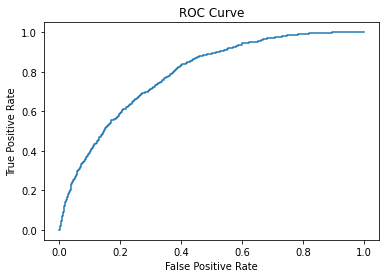

In [ ]:
plt.plot(fpr_lgb, tpr_lgb)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
roc_auc_score(y_val_train_lgb,validation_preds,average='macro')

0.7795423497267759

In [ ]:
probs_lgb_test = np.mean(preds_lgb_test,0)
probs_lgb_train = np.mean(preds_lgb_train,0)
probs_lgb_val = np.mean(preds_lgb_val,0)

In [ ]:
predictions_lgb_test = pd.DataFrame({'LoanNumber': df_test['LoanNumber'], 'Fund':y_test, 'prob': probs_lgb_test})
predictions_lgb_train = pd.DataFrame({'LoanNumber': df_train['LoanNumber'], 'Fund':y_train, 'prob': probs_lgb_train})

In [ ]:
predictions_val['prob_lgb'] = probs_lgb_val
predictions_val.head()

,LoanNumber,prob_rf,prob_lgb
0,9761370643,0.33,0.264037
1,9774670526,0.19,0.097849
2,9773394730,0.09,0.358164
3,9737214560,0.52,0.682315
4,9752609322,0.66,0.665314


In [ ]:
predictions_lgb_train.head()

,LoanNumber,Fund,prob
5323,9710736241,1,0.916534
9795,9720156836,1,0.267858
8338,9727547110,0,0.386227
1548,9793810087,1,0.591690
5750,9793829533,0,0.737399


In [ ]:
print(predictions_lgb_train.shape,predictions_lgb_test.shape)

(9905, 3) (2477, 3)


In [ ]:
pred_df = pd.concat([predictions_lgb_train,predictions_lgb_test])
#pred_df.to_csv('BM_lock_fund_results.csv',index=False)

In [ ]:
stu_df.head()

,LoanNumber,STUDt
0,9713036086,2021-05-19
1,9797657435,None
2,9745002080,2021-01-07
3,9757181152,None
4,9740352050,None


In [ ]:
stu_df['STU_Flag'] = np.where(stu_df['STUDt'].isnull() ==  True, 0, 1)
stu_df.drop('STUDt',axis=1,inplace=True)
stu_df.head()

,LoanNumber,STU_Flag
0,9713036086,1
1,9797657435,0
2,9745002080,1
3,9757181152,0
4,9740352050,0


In [ ]:
predictions_lgb_test = pd.merge(predictions_lgb_test,stu_df,on='LoanNumber',how='left')
pred_df = pd.merge(pred_df,stu_df,on='LoanNumber',how='left')

In [ ]:
# Sort on prediction (descending)
predictions_lgb_test = predictions_lgb_test.sort_values(by = 'prob',ascending=False)
predictions_lgb_test.head()

,LoanNumber,Fund,prob,STU_Flag
760,9791573166,0,0.943100,1
1607,9728700734,1,0.939205,1
1724,9716473161,0,0.937838,1
1253,9772009297,1,0.937124,1
1324,9741063458,1,0.932645,1


In [ ]:
pred_df = pred_df.sort_values(by='prob',ascending=False)

In [ ]:
# data_train = predictions_lgb_train.copy()
data_test = predictions_lgb_test.copy()
data_test.shape

(2477, 4)

In [ ]:
data_full = pred_df.copy()
data_full.shape

(12382, 4)

In [ ]:
def get_gains(data,target_col):
    
    data['row_id'] = range(0,0+len(data))  # Add row ids
    data['decile'] = ( data['row_id'] / (len(data)/10) ).astype(int) # Add decile
    #data.head()
    
    # Check the count by decile
    data.loc[data['decile'] == 10]=9
    data['decile'].value_counts()
    
    #create gains table
    data['decile'] = data['decile']+1
    gains = data.groupby('decile')[target_col,'STU_Flag'].agg(['count','sum']).reset_index()
    gains.columns = ['decile','count','actual_funds','count_STU','STU']
    gains.drop('count_STU',axis=1,inplace=True)
    gains['%STU'] = (gains['STU']/gains['count']).round(2)
    gains['%actual_funds'] = (gains['actual_funds']/gains['count']).round(2)
    
    #add metrics to the gains table
    gains['non_actual_funds'] = gains['count'] - gains['actual_funds']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual_funds'].cumsum()
    gains['cum_non_actual'] = gains['non_actual_funds'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual'] ) * 100
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains = pd.DataFrame(gains)
    gains = gains[['decile', 'count', 'actual_funds', '%actual_funds','STU', '%STU', 'non_actual_funds',
       'cum_count', 'cum_actual', 'cum_non_actual', 'percent_cum_actual',
       'percent_cum_non_actual', 'if_random', 'K_S', 'lift']]
    return gains

In [ ]:
# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

# If,the lift in Decile 1 is 2.5 it means Decile 1 can get 2.5 times of more locks compared to random selection.

get_gains(data_test,'Fund')

,decile,count,actual_funds,%actual_funds,STU,%STU,non_actual_funds,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,248,189,0.76,232,0.94,59,248,189,59,0.21,0.04,91.7,17.0,2.06
1,2,248,161,0.65,210,0.85,87,496,350,146,0.38,0.09,183.4,29.0,1.91
2,3,248,140,0.56,197,0.79,108,744,490,254,0.53,0.16,275.1,37.0,1.78
3,4,247,112,0.45,175,0.71,135,991,602,389,0.66,0.25,366.8,41.0,1.64
4,5,248,99,0.40,161,0.65,149,1239,701,538,0.76,0.34,458.5,42.0,1.53
5,6,248,93,0.38,149,0.60,155,1487,794,693,0.87,0.44,550.2,43.0,1.44
6,7,247,52,0.21,139,0.56,195,1734,846,888,0.92,0.57,641.9,35.0,1.32
7,8,248,43,0.17,119,0.48,205,1982,889,1093,0.97,0.70,733.6,27.0,1.21
8,9,248,24,0.10,104,0.42,224,2230,913,1317,1.00,0.84,825.3,16.0,1.11
9,10,247,4,0.02,119,0.48,243,2477,917,1560,1.00,1.00,917.0,0.0,1.00


In [ ]:
get_gains(data_full,'Fund')

,decile,count,actual_funds,%actual_funds,STU,%STU,non_actual_funds,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,1239,1129,0.91,1210,0.98,110,1239,1129,110,0.25,0.01,458.4,24.0,2.46
1,2,1238,936,0.76,1126,0.91,302,2477,2065,412,0.45,0.05,916.8,40.0,2.25
2,3,1238,764,0.62,1028,0.83,474,3715,2829,886,0.62,0.11,1375.2,51.0,2.06
3,4,1238,618,0.50,897,0.72,620,4953,3447,1506,0.75,0.19,1833.6,56.0,1.88
4,5,1238,479,0.39,808,0.65,759,6191,3926,2265,0.86,0.29,2292.0,57.0,1.71
5,6,1239,317,0.26,708,0.57,922,7430,4243,3187,0.93,0.41,2750.4,52.0,1.54
6,7,1238,211,0.17,621,0.50,1027,8668,4454,4214,0.97,0.54,3208.8,43.0,1.39
7,8,1238,98,0.08,514,0.42,1140,9906,4552,5354,0.99,0.69,3667.2,30.0,1.24
8,9,1238,29,0.02,480,0.39,1209,11144,4581,6563,1.00,0.84,4125.6,16.0,1.11
9,10,1238,3,0.00,586,0.47,1235,12382,4584,7798,1.00,1.00,4584.0,0.0,1.00


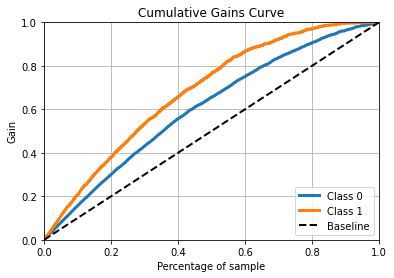

In [ ]:
import scikitplot as skplt
def gain_plot(y,probs):
    
    final_prob_df  = pd.DataFrame({'0': 1-probs,'1':probs})   
    skplt.metrics.plot_cumulative_gain(y,final_prob_df)
    plt.show()

gain_plot(y_test,probs_lgb_test)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

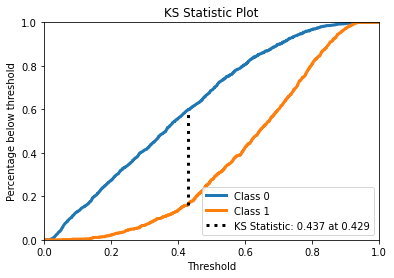

In [ ]:
# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

import scikitplot as skplt
final_prob_df_test  = pd.DataFrame({'0': 1-probs_lgb_test,'1':probs_lgb_test})
skplt.metrics.plot_ks_statistic(y_test, final_prob_df_test)

In [ ]:
## K-S Two Sample Test
# One sample have the prob scores corresponding to non-events and another sample corresponds to events.
from scipy.stats import ks_2samp
ks_2samp(final_prob_df_test['0'], final_prob_df_test['1'],mode='exact')

KstestResult(statistic=0.0904319741622931, pvalue=3.1144592687154905e-09)

<AxesSubplot:xlabel='Fund', ylabel='prob'>

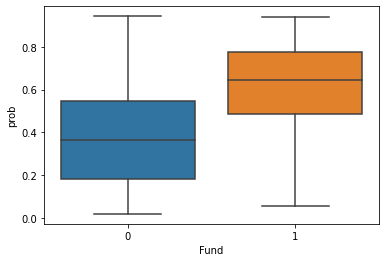

In [ ]:
import seaborn as sns
sns.boxplot(y = 'prob',x = 'Fund',data=predictions_lgb_test)

In [ ]:
predictions_lgb_test[predictions_lgb_test['Fund']==0]['prob'].mean(),predictions_lgb_test[predictions_lgb_test['Fund']==1]['prob'].mean()

(0.3776154984732153, 0.6203874525413672)

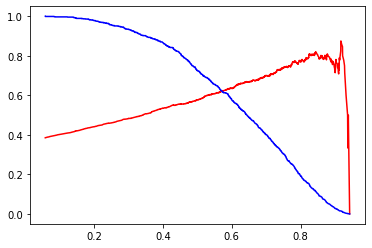

In [ ]:
from sklearn.metrics import precision_recall_curve
precision_lgb, recall_lgb, thresholds_lgb = precision_recall_curve(predictions_lgb_test['Fund'], predictions_lgb_test.prob)

plt.plot(thresholds_lgb, precision_lgb[:-1], "r-")
plt.plot(thresholds_lgb, recall_lgb[:-1], "b-")
plt.show()

In [ ]:
predictions_lgb_test.head()

,LoanNumber,Fund,prob,STU_Flag
760,9791573166,0,0.943100,1
1607,9728700734,1,0.939205,1
1724,9716473161,0,0.937838,1
1253,9772009297,1,0.937124,1
1324,9741063458,1,0.932645,1


In [ ]:
y_pred_lgb = np.where(np.array(predictions_lgb_test.prob) > 0.57,1,0)

In [ ]:
print(pd.crosstab(predictions_lgb_test['Fund'],  y_pred_lgb, rownames=['Actual'], colnames=['Predicted']))

Predicted     0    1
Actual              
0          1213  347
1           346  571


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions_lgb_test['Fund'], y_pred_lgb))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1560
           1       0.62      0.62      0.62       917

    accuracy                           0.72      2477
   macro avg       0.70      0.70      0.70      2477
weighted avg       0.72      0.72      0.72      2477



In [ ]:
# df1 = pd.read_csv('C:/CHL/portfolio_lock_fund_final_08_31.csv')

In [ ]:
# df[df['STUDt'].isnull() == True].shape

### XGBoost

In [ ]:
import xgboost as xgb
#def xgb_training(df, y, random_seed = 0):
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import roc_curve, auc
xgb_auc_score = []

preds_xgb = []
preds_val_xgb = []

xgbfold=StratifiedKFold(n_splits=10, random_state=random_seed, shuffle=True)

i = 1
print(f"Seed: {random_seed}")

for train_idx, val_idx in xgbfold.split(X_train, y_train):
    X_train_1, X_val_1 = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_1, y_val_1 = y_train.iloc[train_idx], y_train.iloc[val_idx]

    test_data = X_test.copy(deep=True)

    params = {
     "objective" : "binary:logistic",
     "eval_metric" : "auc",
     "max_depth" : 6,
     "eta" : 0.1,
     "subsample" : 0.8,
     "colsample_bytree" : 0.8,
     "min_child_weight" : 10,
     "max_bin" : 16,
     "seed" : random_seed
    }

    xgtrain = xgb.DMatrix(X_train_1, label=y_train_1)
    xgval = xgb.DMatrix(X_val_1, label=y_val_1)
    watchlist = [ (xgtrain,'train'), (xgval, 'valid') ]

    xgb_model = xgb.train(params
                          , xgtrain
                          , 3000
                          , watchlist
                          , early_stopping_rounds=100
                          , verbose_eval=100
                         )

    validation_preds_xgb = xgb_model.predict(xgval, ntree_limit=xgb_model.best_ntree_limit)

    fea_imp=pd.DataFrame(list(xgb_model.get_fscore().items()), columns=['col','imp'])
    fea_imp = fea_imp.sort_values('imp', ascending=False)
    print(f"\n{fea_imp.head(10)}")

    test_preds_xgb = xgb_model.predict(xgb.DMatrix(test_data), ntree_limit=xgb_model.best_ntree_limit)
    preds_xgb.append(test_preds_xgb)
    
    val_preds_xgb = xgb_model.predict(xgb.DMatrix(X_val), ntree_limit=xgb_model.best_ntree_limit)
    preds_val_xgb.append(val_preds_xgb)
    
    auc = round(roc_auc_score(y_val_1, validation_preds_xgb), 5)

    print(f"\nFold {i}, AUC Score: {auc}")

    xgb_auc_score.append(auc)

    i = i+1

    print('\nCross validated AUC: {}\n'.format(np.mean(xgb_auc_score)))

print(f'AUC Scores: {xgb_auc_score}\n')

#return(preds_xgb)

Seed: 12345
[0]	train-auc:0.71739	valid-auc:0.67490
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 100 rounds.
[100]	train-auc:0.88400	valid-auc:0.76076
[200]	train-auc:0.93183	valid-auc:0.76389
Stopping. Best iteration:
[174]	train-auc:0.92157	valid-auc:0.76629


                                          col  imp
12                                        DTI  626
4                       BCalcTotalLiabilities  601
9                                     LoanAmt  580
13  BCalcUnderwritingTotalStableMonthlyIncome  572
15                                        LTV  565
1                                        FICO  501
3                                  FinalPrice  490
14               BCalcBaseUPBFinalPriceAmount  477
7                             prevailing_rate  381
5                                        Rate  253

Fold 1, AUC Score: 0.76629

Cross validated AUC: 0.76629

[0]	train-auc:0.71602	valid-au

In [ ]:
fea_imp=pd.DataFrame(list(xgb_model.get_fscore().items()), columns=['col','imp'])
fea_imp = fea_imp.sort_values('imp', ascending=False)
fea_imp

,col,imp
16,DTI,493
12,BCalcUnderwritingTotalStableMonthlyIncome,436
2,BCalcTotalLiabilities,407
15,LTV,405
3,FinalPrice,363
4,LoanAmt,358
1,FICO,343
13,BCalcBaseUPBFinalPriceAmount,326
5,prevailing_rate,277
11,Rate,172


In [ ]:
np.shape(preds_xgb)

(10, 2477)

In [ ]:
np.shape(preds_val_xgb)

(10, 1455)

In [ ]:
predictions_val['prob_xgb'] = np.mean(preds_val_xgb,0)
predictions_val.head()

,LoanNumber,prob_rf,prob_lgb,prob_xgb
0,9761370643,0.33,0.264037,0.230431
1,9774670526,0.19,0.097849,0.043550
2,9773394730,0.09,0.358164,0.261336
3,9737214560,0.52,0.682315,0.666555
4,9752609322,0.66,0.665314,0.545386


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, np.mean(preds_xgb,0))

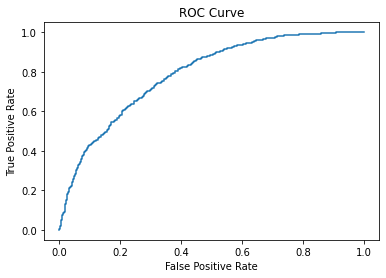

In [ ]:
plt.plot(fpr_xgb, tpr_xgb)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
np.shape(validation_preds_xgb)

(990,)

In [ ]:
from sklearn.metrics import roc_curve, auc
roc_auc_score(y_test,np.mean(preds_xgb,0),average='macro')

0.787063445460392

In [ ]:
probs_xgb_test = np.mean(preds_xgb,0)

In [ ]:
predictions_xgb_test = pd.DataFrame({'LoanNumber': df_test['LoanNumber'], 'Fund':y_test, 'prob': probs_xgb_test})

In [ ]:
# Sort on prediction (descending)
predictions_xgb_test = predictions_xgb_test.sort_values(by = 'prob',ascending=False)
predictions_xgb_test.head()

,LoanNumber,Fund,prob
10565,9798841988,0,0.937105
11254,9715942885,1,0.931497
344,9720619445,1,0.931108
5175,9750114937,1,0.929734
5526,9776876584,1,0.920724


In [ ]:
data_test_xgb = predictions_xgb_test.copy()

In [ ]:
def get_gains(data,target_col):
    
    data['row_id'] = range(0,0+len(data))  # Add row ids
    data['decile'] = ( data['row_id'] / (len(data)/10) ).astype(int) # Add decile
    #data.head()
    
    # Check the count by decile
    data.loc[data['decile'] == 10]=9
    data['decile'].value_counts()
    
    #create gains table
    data['decile'] = data['decile']+1
    gains = data.groupby('decile')[target_col].agg(['count','sum']).reset_index()
    gains.columns = ['decile','count','actual_funds']
    gains
    
    #add metrics to the gains table
    gains['non_actual_funds'] = gains['count'] - gains['actual_funds']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual_funds'].cumsum()
    gains['cum_non_actual'] = gains['non_actual_funds'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual'] ) * 100
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains = pd.DataFrame(gains)
    return gains

In [ ]:
# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

# If,the lift in Decile 1 is 2.5 it means Decile 1 can get 2.5 times of more locks compared to random selection.

get_gains(data_test_xgb,'Fund')

,decile,count,actual_funds,non_actual_funds,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,248,196,52,248,196,52,0.21,0.03,91.7,18.0,2.14
1,2,248,167,81,496,363,133,0.40,0.09,183.4,31.0,1.98
2,3,248,121,127,744,484,260,0.53,0.17,275.1,36.0,1.76
3,4,247,114,133,991,598,393,0.65,0.25,366.8,40.0,1.63
4,5,248,100,148,1239,698,541,0.76,0.35,458.5,41.0,1.52
5,6,248,88,160,1487,786,701,0.86,0.45,550.2,41.0,1.43
6,7,247,61,186,1734,847,887,0.92,0.57,641.9,35.0,1.32
7,8,248,43,205,1982,890,1092,0.97,0.70,733.6,27.0,1.21
8,9,248,21,227,2230,911,1319,0.99,0.85,825.3,14.0,1.10
9,10,247,6,241,2477,917,1560,1.00,1.00,917.0,0.0,1.00


In [ ]:
# Cost benefit analysis
# each decile benefit, savings
# response rate

In [ ]:
import scikitplot as skplt
def gain_plot(y,probs):
    
    final_prob_df  = pd.DataFrame({'0': 1-probs,'1':probs})   
    skplt.metrics.plot_cumulative_gain(y,final_prob_df)
    plt.show()

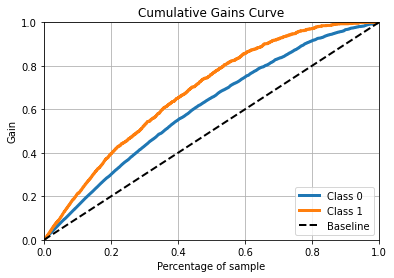

In [ ]:
gain_plot(y_test,probs_xgb_test)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

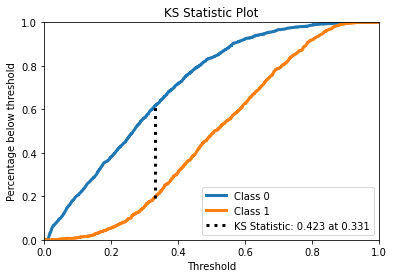

In [ ]:
# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

import scikitplot as skplt
final_prob_df_test_xgb  = pd.DataFrame({'0': 1-probs_xgb_test,'1':probs_xgb_test})
skplt.metrics.plot_ks_statistic(y_test, final_prob_df_test_xgb)

In [ ]:
## K-S Two Sample Test
# One sample have the prob scores corresponding to non-events and another sample corresponds to events.
from scipy.stats import ks_2samp
ks_2samp(final_prob_df_test_xgb['0'], final_prob_df_test_xgb['1'],mode='exact')

KstestResult(statistic=0.4162293096487687, pvalue=1.5114641183631344e-192)

<AxesSubplot:xlabel='Fund', ylabel='prob'>

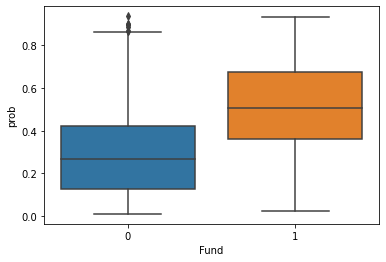

In [ ]:
import seaborn as sns
sns.boxplot(y = 'prob',x = 'Fund',data=predictions_xgb_test)

In [ ]:
predictions_xgb_test[predictions_xgb_test['Fund']==1]['prob'].mean(), predictions_xgb_test[predictions_xgb_test['Fund']==0]['prob'].mean()

(0.51704454, 0.29121804)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(predictions_xgb_test.Fund, predictions_xgb_test.prob)

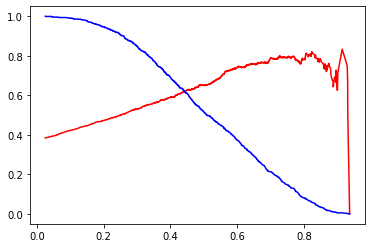

In [ ]:
plt.plot(thresholds_xgb, precision_xgb[:-1], "r-")
plt.plot(thresholds_xgb, recall_xgb[:-1], "b-")
plt.show()

In [ ]:
predictions_xgb_test.head()

,LoanNumber,Fund,prob
10565,9798841988,0,0.937105
11254,9715942885,1,0.931497
344,9720619445,1,0.931108
5175,9750114937,1,0.929734
5526,9776876584,1,0.920724


In [ ]:
y_pred_xgb = np.where(np.array(predictions_xgb_test.prob) > 0.45,1,0)

In [ ]:
print(pd.crosstab(predictions_xgb_test.Fund,  y_pred_xgb, rownames=['Actual'], colnames=['Predicted']))

Predicted     0    1
Actual              
0          1226  334
1           359  558


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions_xgb_test.Fund, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      1560
           1       0.63      0.61      0.62       917

    accuracy                           0.72      2477
   macro avg       0.70      0.70      0.70      2477
weighted avg       0.72      0.72      0.72      2477



### catboost

In [ ]:
from catboost import CatBoostClassifier, Pool
random_seed = 12345

preds_cb = []
preds_val_cb = []
preds_train_cb = []
cb_auc_score =[]

cbfold=StratifiedKFold(n_splits=10, random_state=random_seed, shuffle=True)
i = 1
print(f"Seed: {random_seed}")
for train_idx, val_idx in cbfold.split(X_train, y_train):
    X_train_2, X_val_2 = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_2, y_val_2 = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # training the model on oversampled 5 folds of training set
    cb = CatBoostClassifier(n_estimators=3000,
                             verbose = 250,
                             eval_metric='AUC',
                             depth = 6,
                             learning_rate = 0.1,
                             od_type = "Iter",
                             od_wait = 100,
                             rsm=0.8,
                             random_state=random_seed
                            )

    cb.fit(X_train_2, y_train_2, eval_set=[(X_val_2, y_val_2)])
    
    # testing on 1 fold of validation set
    validation_preds_cb = cb.predict_proba(X_val_2)

    fea_imp = pd.DataFrame({'col': X_train_2.columns, 'imp': cb.feature_importances_})
    fea_imp = fea_imp.sort_values('imp', ascending=False)
    print(fea_imp.head(10))


    test_preds_cb = cb.predict_proba(X_test)
    preds_cb.append(test_preds_cb[:,1])
    
    val_preds_cb = cb.predict_proba(X_val)
    preds_val_cb.append(val_preds_cb[:,1])
    
    train_preds_cb = cb.predict_proba(X_train)
    preds_train_cb.append(train_preds_cb[:,1])
    
    auc_score = round(roc_auc_score(y_val_2, validation_preds_cb[:,1]), 5)

    print(f"\nFold {i}, AUC Score: {auc_score}")
        
    cb_auc_score.append(auc_score)


    i = i+1
    
    print('\nCross validated AUC: {}\n'.format(np.mean(cb_auc_score)))
        
    print(f'AUC Scores: {cb_auc_score}\n')

Seed: 12345
0:	test: 0.7216167	best: 0.7216167 (0)	total: 57.3ms	remaining: 2m 51s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7652745756
bestIteration = 96

Shrink model to first 97 iterations.
                                          col        imp
8                                         DTI  25.323970
18               BCalcBaseUPBFinalPriceAmount   8.721740
20                             Campaign_Group   7.025910
17  BCalcUnderwritingTotalStableMonthlyIncome   6.326741
14                                 FinalPrice   5.790785
1                                ProductGroup   5.575935
6                                         LTV   4.976339
2                                    LoanType   4.284692
5                                        FICO   4.262652
7                                        Rate   3.566385

Fold 1, AUC Score: 0.76527

Cross validated AUC: 0.76527

AUC Scores: [0.76527]

0:	test: 0.6907029	best: 0.6907029 (0)	total: 7.53ms	remaining: 22.6s
2

In [ ]:
fea_imp = pd.DataFrame({'col': X_train_2.columns, 'imp': cb.feature_importances_})
fea_imp = fea_imp.sort_values('imp', ascending=False)
pd.DataFrame(fea_imp).head(20)

,col,imp
8,DTI,24.263635
18,BCalcBaseUPBFinalPriceAmount,7.405220
6,LTV,7.050163
14,FinalPrice,6.628046
17,BCalcUnderwritingTotalStableMonthlyIncome,6.226909
20,Campaign_Group,4.820919
5,FICO,4.766024
1,ProductGroup,4.205030
16,BCalcTotalLiabilities,3.989397
3,DocumentType,3.853991


In [ ]:
cb_auc_score

[0.76527,
 0.77509,
 0.78628,
 0.79071,
 0.78859,
 0.78508,
 0.77017,
 0.77029,
 0.79231,
 0.79682]

In [ ]:
np.mean(cb_auc_score)

0.7820609999999999

In [ ]:
np.shape(preds_cb)

(10, 2477)

In [ ]:
np.shape(preds_train_cb)

(10, 9905)

In [ ]:
predictions_val['probs_cb'] = np.mean(preds_val_cb,0)
predictions_val.head()

,LoanNumber,prob_rf,prob_lgb,prob_xgb,probs_cb
0,9761370643,0.33,0.264037,0.230431,0.201297
1,9774670526,0.19,0.097849,0.043550,0.063892
2,9773394730,0.09,0.358164,0.261336,0.132226
3,9737214560,0.52,0.682315,0.666555,0.623558
4,9752609322,0.66,0.665314,0.545386,0.560965


In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_cb, tpr_cb, thresholds_cb = roc_curve(y_test, np.mean(preds_cb,0))

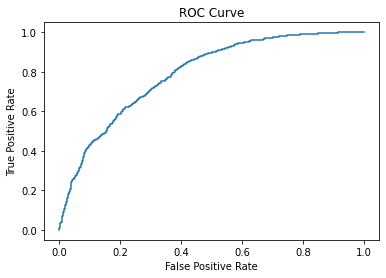

In [ ]:
plt.plot(fpr_cb, tpr_cb)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
roc_auc_score(y_test, np.mean(preds_cb,0),average='macro')

0.7891584878226099

In [ ]:
probs_cb_test = np.mean(preds_cb,0)

In [ ]:
probs_cb_train = np.mean(preds_train_cb,0)

In [ ]:
predictions_cb_test = pd.DataFrame({'LoanNumber': df_test['LoanNumber'], 'Fund':y_test, 'prob': probs_cb_test})
predictions_cb_train = pd.DataFrame({'LoanNumber': df_train['LoanNumber'], 'Fund':y_train, 'prob': probs_cb_train})

In [ ]:
print(predictions_cb_train.shape)
print(predictions_cb_test.shape)

(9905, 3)
(2477, 3)


In [ ]:
predictions = pd.concat([predictions_cb_train,predictions_cb_test])
predictions.shape

(12382, 3)

In [ ]:
predictions_cb_test = pd.merge(predictions_cb_test,stu_df,on='LoanNumber',how='left')
predictions = pd.merge(predictions,stu_df,on='LoanNumber',how='left')

In [ ]:
# Sort on prediction (descending)
predictions_cb_test = predictions_cb_test.sort_values(by = 'prob',ascending=False)
predictions_cb_test.head()

,LoanNumber,Fund,prob,STU_Flag
1905,9776876584,1,0.956585,1
104,9711252248,1,0.942983,1
1776,9720619445,1,0.940980,1
1600,9752764275,1,0.939562,1
1312,9798841988,0,0.934942,1


In [ ]:
predictions = predictions.sort_values(by='prob',ascending=False)
predictions.head()

,LoanNumber,Fund,prob,STU_Flag
9886,9717097076,1,0.976623,1
1670,9762654573,1,0.975515,1
3266,9785683237,1,0.967073,1
2194,9785184913,1,0.963098,1
8585,9763780534,1,0.960421,1


In [ ]:
data_test_cb = predictions_cb_test.copy()
data_full = predictions.copy()

In [ ]:
def get_gains(data,target_col):
    
    data['row_id'] = range(0,0+len(data))  # Add row ids
    data['decile'] = ( data['row_id'] / (len(data)/10) ).astype(int) # Add decile
    #data.head()
    
    # Check the count by decile
    data.loc[data['decile'] == 10]=9
    data['decile'].value_counts()
    
    #create gains table
    data['decile'] = data['decile']+1
    gains = data.groupby('decile')[target_col,'STU_Flag'].agg(['count','sum']).reset_index()
    gains.columns = ['decile','count','actual_funds','count_STU','STU']
    gains.drop('count_STU',axis=1,inplace=True)
    gains['%STU'] = (gains['STU']/gains['count']).round(2)
    gains['%actual_funds'] = (gains['actual_funds']/gains['count']).round(2)
    
    #add metrics to the gains table
    gains['non_actual_funds'] = gains['count'] - gains['actual_funds']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual_funds'].cumsum()
    gains['cum_non_actual'] = gains['non_actual_funds'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['K_S'] = np.abs( gains['percent_cum_actual'] - gains['percent_cum_non_actual'] ) * 100
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains = pd.DataFrame(gains)
    gains = gains[['decile', 'count', 'actual_funds', '%actual_funds','STU', '%STU', 'non_actual_funds',
       'cum_count', 'cum_actual', 'cum_non_actual', 'percent_cum_actual',
       'percent_cum_non_actual', 'if_random', 'K_S', 'lift']]
    return gains

In [ ]:
# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

# If,the lift in Decile 1 is 2.5 it means Decile 1 can get 2.5 times of more locks compared to random selection.

get_gains(data_test_cb,'Fund')

,decile,count,actual_funds,%actual_funds,STU,%STU,non_actual_funds,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,248,190,0.77,234,0.94,58,248,190,58,0.21,0.04,91.7,17.0,2.07
1,2,248,173,0.70,218,0.88,75,496,363,133,0.40,0.09,183.4,31.0,1.98
2,3,248,122,0.49,192,0.77,126,744,485,259,0.53,0.17,275.1,36.0,1.76
3,4,247,112,0.45,171,0.69,135,991,597,394,0.65,0.25,366.8,40.0,1.63
4,5,248,97,0.39,154,0.62,151,1239,694,545,0.76,0.35,458.5,41.0,1.51
5,6,248,98,0.40,154,0.62,150,1487,792,695,0.86,0.45,550.2,41.0,1.44
6,7,247,61,0.25,134,0.54,186,1734,853,881,0.93,0.56,641.9,37.0,1.33
7,8,248,38,0.15,123,0.50,210,1982,891,1091,0.97,0.70,733.6,27.0,1.21
8,9,248,20,0.08,105,0.42,228,2230,911,1319,0.99,0.85,825.3,14.0,1.10
9,10,247,6,0.02,120,0.49,241,2477,917,1560,1.00,1.00,917.0,0.0,1.00


In [ ]:
get_gains(data_full,'Fund')

,decile,count,actual_funds,%actual_funds,STU,%STU,non_actual_funds,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,K_S,lift
0,1,1239,1129,0.91,1210,0.98,110,1239,1129,110,0.25,0.01,458.4,24.0,2.46
1,2,1238,936,0.76,1126,0.91,302,2477,2065,412,0.45,0.05,916.8,40.0,2.25
2,3,1238,764,0.62,1028,0.83,474,3715,2829,886,0.62,0.11,1375.2,51.0,2.06
3,4,1238,618,0.50,897,0.72,620,4953,3447,1506,0.75,0.19,1833.6,56.0,1.88
4,5,1238,479,0.39,808,0.65,759,6191,3926,2265,0.86,0.29,2292.0,57.0,1.71
5,6,1239,317,0.26,708,0.57,922,7430,4243,3187,0.93,0.41,2750.4,52.0,1.54
6,7,1238,211,0.17,621,0.50,1027,8668,4454,4214,0.97,0.54,3208.8,43.0,1.39
7,8,1238,98,0.08,514,0.42,1140,9906,4552,5354,0.99,0.69,3667.2,30.0,1.24
8,9,1238,29,0.02,480,0.39,1209,11144,4581,6563,1.00,0.84,4125.6,16.0,1.11
9,10,1238,3,0.00,586,0.47,1235,12382,4584,7798,1.00,1.00,4584.0,0.0,1.00


In [ ]:
# Cost benefit analysis
# each decile benefit, savings
# response rate

In [ ]:
import scikitplot as skplt
def gain_plot(y,probs):
    
    final_prob_df  = pd.DataFrame({'0': 1-probs,'1':probs})   
    skplt.metrics.plot_cumulative_gain(y,final_prob_df)
    plt.show()

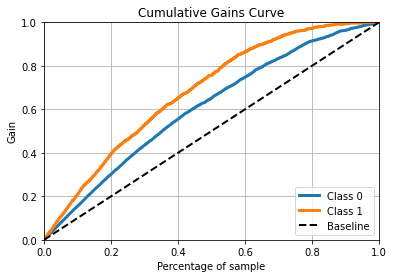

In [ ]:
gain_plot(y_test,probs_cb_test)

<AxesSubplot:title={'center':'KS Statistic Plot'}, xlabel='Threshold', ylabel='Percentage below threshold'>

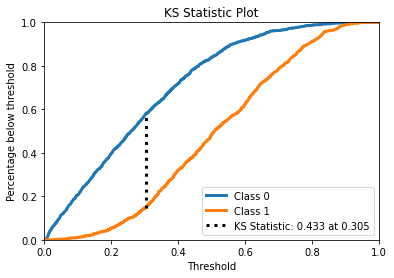

In [ ]:
# K-S measures the degree of separation between the distributions of the positive and negative responders. 
# If a model cannot separate positive from negative cases, the K-S for all deciles will be 0. 

import scikitplot as skplt
final_prob_df_test_cb  = pd.DataFrame({'0': 1-probs_cb_test,'1':probs_cb_test})
skplt.metrics.plot_ks_statistic(y_test, final_prob_df_test_cb)

In [ ]:
## K-S Two Sample Test
# One sample have the prob scores corresponding to non-events and another sample corresponds to events.
from scipy.stats import ks_2samp
ks_2samp(final_prob_df_test_cb['0'], final_prob_df_test_cb['1'],mode='exact')

KstestResult(statistic=0.41501816713766654, pvalue=2.1473341232187026e-191)

<AxesSubplot:xlabel='Fund', ylabel='prob'>

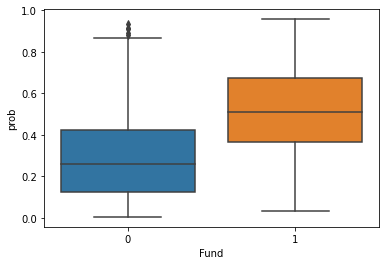

In [ ]:
import seaborn as sns
sns.boxplot(y = 'prob',x = 'Fund',data=predictions_cb_test)

In [ ]:
predictions_cb_test[predictions_cb_test['Fund']==1]['prob'].mean(), predictions_cb_test[predictions_cb_test['Fund']==0]['prob'].mean()

(0.5181430280452408, 0.2888355364526122)

In [ ]:
from sklearn.metrics import precision_recall_curve
precision_cb, recall_cb, thresholds_cb = precision_recall_curve(predictions_cb_test.Fund, predictions_cb_test.prob)

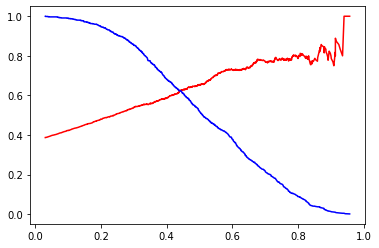

In [ ]:
plt.plot(thresholds_cb, precision_cb[:-1], "r-")
plt.plot(thresholds_cb, recall_cb[:-1], "b-")
plt.show()

In [ ]:
predictions_cb_test.head()

,LoanNumber,Fund,prob,STU_Flag
1905,9776876584,1,0.956585,1
104,9711252248,1,0.942983,1
1776,9720619445,1,0.940980,1
1600,9752764275,1,0.939562,1
1312,9798841988,0,0.934942,1


In [ ]:
y_pred_cb = np.where(np.array(predictions_cb_test.prob) > 0.46,1,0)

In [ ]:
print(pd.crosstab(predictions_cb_test.Fund,  y_pred_cb, rownames=['Actual'], colnames=['Predicted']))

Predicted     0    1
Actual              
0          1244  316
1           376  541


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(predictions_cb_test.Fund, y_pred_cb))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      1560
           1       0.63      0.59      0.61       917

    accuracy                           0.72      2477
   macro avg       0.70      0.69      0.70      2477
weighted avg       0.72      0.72      0.72      2477



#### shap values

In [ ]:
import shap

In [ ]:
explainer = shap.TreeExplainer(cb)

In [ ]:
shap_values_train = explainer.shap_values(X_train_2)

In [ ]:
shap_values_test = explainer.shap_values(X_val_2)

In [ ]:
def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'blue','red')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = False)
    colorlist = k2['Sign']
    #return k2
    k2 = k2.head(20)
    #return k2
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(10,10),legend=False)
    ax.invert_yaxis()
    ax.set_xlabel("SHAP Value (Blue = Positive Impact)")

In [ ]:
shap_values_test.shape

(990, 23)

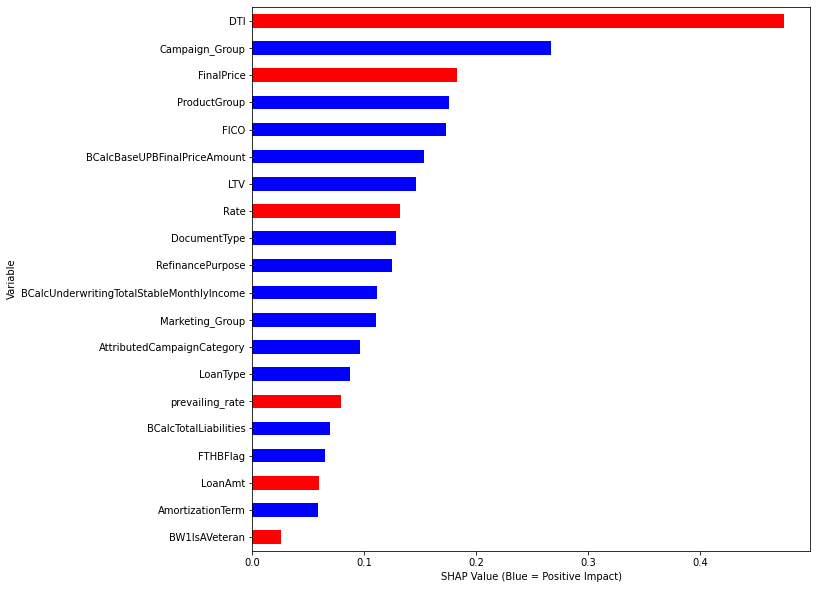

In [ ]:
ABS_SHAP(shap_values_train, X_train_2)

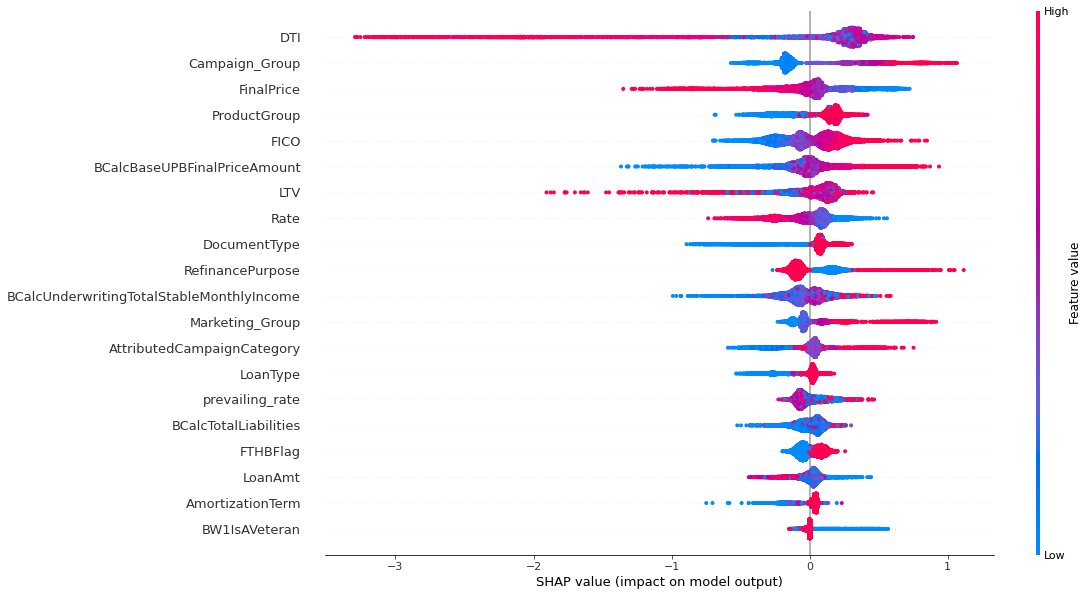

In [ ]:
shap.summary_plot(shap_values_train, X_train_2,plot_size=(15, 10))

### pipeline results

In [ ]:
predictions_val.head()

,LoanNumber,prob_rf,prob_lgb,prob_xgb,probs_cb
0,9761370643,0.33,0.264037,0.230431,0.201297
1,9774670526,0.19,0.097849,0.043550,0.063892
2,9773394730,0.09,0.358164,0.261336,0.132226
3,9737214560,0.52,0.682315,0.666555,0.623558
4,9752609322,0.66,0.665314,0.545386,0.560965


In [ ]:
predictions_val[['prob_rf','prob_lgb']].describe()

,prob_rf,prob_lgb
count,1455.000000,1455.000000
mean,0.370110,0.447687
std,0.181808,0.209591
min,0.010000,0.016382
25%,0.235000,0.294166
50%,0.350000,0.440157
75%,0.490000,0.599330
max,0.940000,0.942944


In [ ]:
test.head()

,LoanNumber,LoanAmt,ProductGroup,LoanType,DocumentType,AmortizationTerm,FICO,LTV,Rate,DTI,ResidencyType,PropertyType,NumberOfUnits,RefinancePurpose,FTHBFlag,FinalPrice,BW1IsAVeteran,BCalcTotalLiabilities,BCalcUnderwritingTotalStableMonthlyIncome,BCalcBaseUPBFinalPriceAmount,AttributedCampaignCategory,Campaign_Group,Marketing_Group,prevailing_rate
0,9761370643,269000.0,41.141350,41.157620,38.555162,360,774.0,74.723,3.990,23.290,40.001216,36.773593,1,37.350591,36.936812,1.743,37.299052,570807.0,10000.00,-4688.6700,36.168030,33.064650,33.331099,3.21
1,9774670526,256400.0,41.141350,41.157620,38.555162,240,725.0,54.554,2.850,60.321,36.410371,36.773593,1,36.467579,36.936812,0.788,37.299052,377412.0,9697.04,-2020.4320,42.031019,46.923598,46.592259,3.24
2,9773394730,259462.0,28.745766,28.714972,38.555162,360,605.0,78.462,2.650,54.369,36.410371,36.773593,1,36.416264,37.124112,2.601,37.299052,132493.0,6416.80,-6748.6066,33.841733,33.816757,28.819603,3.07
3,9737214560,103500.0,41.141350,41.157620,38.555162,360,793.0,29.572,3.125,33.887,38.963032,36.773593,1,36.467579,37.124112,-0.010,37.299052,114263.0,5514.02,10.3500,38.114031,46.923598,37.749477,3.16
4,9752609322,348642.0,28.745766,28.714972,32.395987,360,680.0,85.662,3.000,0.000,36.410371,36.773593,1,36.467579,36.936812,-1.292,37.299052,0.0,0.00,4504.4546,36.168030,33.064650,33.331099,3.21


In [ ]:
test.shape

(1455, 24)

In [ ]:
test['LoanNumber'].nunique()

1455

In [ ]:
pipeline_preds = pd.merge(test,predictions_val,how='left',on='LoanNumber')
pipeline_preds.shape

(1455, 28)

In [ ]:
predictions_val.to_csv('BM_pipeline_preds_03_12_21.csv',index=False)